# State HFM

This notebook demonstrates the implementation of path planning algorithms for autonomous forklifts with four-wheel steering capabilities. We will explore how to combine advanced motion control with state-based planning to achieve efficient and natural navigation behaviors.

## 0. Importing required libraries

In [1]:
import sys
import os

current_dir = os.path.abspath(os.getcwd())

from agd import Eikonal 
from agd import AutomaticDifferentiation as ad
from agd import Plotting
from scipy import ndimage
import time
import subprocess

In [2]:
import numpy as np; xp = np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

try :import cupy
except ModuleNotFoundError: raise ad.DeliberateNotebookError("A cuda enabled gpu is required for this notebook")

xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .


### 0.1 Utility fonction

In [3]:
def control_source(activeNeighs,ncontrols,control_default=np.nan,source_default=np.nan):
    """
    Returns the optimal control, or the source of the optimal jump, at each point reached 
    by the front.
    Input : 
     - activeNeighs : produced by the eikonal solver, with option 'exportActiveNeighs':True
     - ncontrols : number of controls of the model (needed in case of several states)
     - control default : when no control is used (jump to another state, or stationnary point)
     - jump default : when no jump is done (following a control vector, or stationnary point)
    Output : 
     - control : the index of the control used
     - source (only if several states) : the index of the source state of the jump
    """
    nstates = activeNeighs.shape[-1]
    ndim = activeNeighs.ndim
    decompdim = (ndim*(ndim-1))//2
    active = activeNeighs%(2**decompdim)
    stationnary = (active==0) # No control used. Seeds and non reachable points (e.g. inside walls)
    control = np.where(stationnary,control_default,activeNeighs//(2**decompdim)) 
    assert np.all(control[~stationnary]<ncontrols+(nstates>1))
    if nstates==1: return control # Model with a single state
    jump = (~stationnary) & (control==ncontrols) # Points where the optimal option is to jump to a different state
    source = np.log2(active).round().astype(int) # source of the jump
    source = np.where(jump,source + (source>=xp.arange(nstates)), source_default)
    return np.where(control==ncontrols,control_default,control),source

In [79]:
def draw_bot(gamma,
             nb_pt = 10, 
             zoom_factor = 1., 
             bot_dim=np.array([3.6490,0.7000]),
             offset = np.array([0.4845,0]),
             wheelbase = 1.38,
             colors=['g','y','r']):
    """
    Draw the figure of the robot allong the path.
    Input :
     - gamma : the path
     - nb_pt : number of points where the robot is drawn
     - zoom_factor : multiplicative factor to scale the shape of robot
     - bot_dim : dimension of the robot when 1 pixel length = 1 meter
     - offset : position of the center of the rear axle along the length of the robot in m
     - wheelbase : distance between the front and the rear axle in m
     - colors : colors of the first position, intermediary positions and the final position
    """
    offset_zoom = offset*zoom_factor
    bot_dim_zoom = bot_dim*zoom_factor
    wheelbase_zoom = wheelbase*zoom_factor
    
    rlength = bot_dim_zoom[0]-offset_zoom[0]
    rwidth = bot_dim_zoom[1]
    bot_dim_zoom = [rlength,offset_zoom[0],0.5*rwidth,0.5*rwidth]
    
    length_front = bot_dim_zoom[0] #length between the center of the rear axle and the front of the robot
    length_back = bot_dim_zoom[1] #length between the center of the rear axle and the back of the robot
    width_left = bot_dim_zoom[2] #length between the center of the rear axle and the left of the robot
    width_right = bot_dim_zoom[3] #length between the center of the rear axle and the right of the robot
    
    bot = [-length_front-width_left*1j,-length_front+width_right*1j,length_back-width_left*1j,length_back+width_right*1j]
    # coordinates of each corner of the rectangular shape of the robot using complex number
    
    pt = []
    for i in range(len(gamma[0])): # For each points in the path we calculate the position of the four corners and of the center of the center and extrems points of the front axle
        xx = bot[0]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        xy = bot[1]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        yx = bot[2]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        yy = bot[3]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        lfcenter = (-bot_dim_zoom[0]/2.+bot_dim_zoom[2]*1j)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        rfcenter = (-bot_dim_zoom[0]/2.-bot_dim_zoom[3]*1j)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        fcenter = (-wheelbase_zoom)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        pt.append([xx,yx,xy,yy,lfcenter,rfcenter,fcenter])
    pt = xp.array(pt)
    pt = pt.get()
    
    w=(np.linspace(0,len(gamma[0])-1,nb_pt)).astype(int) #selecting the points on the path where to plot the robot shape
    #plotting the robot
    for c in w :
        plt.plot(np.real([pt[c,0],pt[c,1]]),np.imag([pt[c,0],pt[c,1]]),colors[1])
        plt.plot(np.real([pt[c,2],pt[c,3]]),np.imag([pt[c,2],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,1],pt[c,3]]),np.imag([pt[c,1],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,1],pt[c,3]]),np.imag([pt[c,1],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,4],pt[c,5]]),np.imag([pt[c,4],pt[c,5]]),colors[1])
    #plotting start and finish positions of the robot
    if len(w)!= 0: 
        plt.plot(np.real([pt[-1,0],pt[-1,1]]),np.imag([pt[c,0],pt[c,1]]),colors[2])
        plt.plot(np.real([pt[-1,2],pt[-1,3]]),np.imag([pt[c,2],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,1],pt[-1,3]]),np.imag([pt[c,1],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,1],pt[-1,3]]),np.imag([pt[c,1],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,4],pt[-1,5]]),np.imag([pt[c,4],pt[c,5]]),colors[2])
        
        plt.plot(np.real([pt[0,0],pt[0,1]]),np.imag([pt[0,0],pt[0,1]]),colors[0])
        plt.plot(np.real([pt[0,2],pt[0,3]]),np.imag([pt[0,2],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,1],pt[0,3]]),np.imag([pt[0,1],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,1],pt[0,3]]),np.imag([pt[0,1],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,4],pt[0,5]]),np.imag([pt[0,4],pt[0,5]]),colors[0])

## 1. Building the environement

In [67]:
map_path = os.path.join(current_dir, "benoit_world_zoom.png") # Path to the binary map

Nx = 100 # Number of points along the x-axis
Ny = 100 # Number of points along the y-axis
Nθ = 100 # Number of points along the angular dimension
Θ = np.linspace(0,2*np.pi,Nθ,endpoint=False)
zoom_factor = 3 # Zoom factor to scale the robot shape accordingly to the input
rlength = 3.6490 # Length of the robot in m
rwidth = 0.7 # Width of the robot in m
wheelbase = 1.38 # Distance between the front and the rear axle
offset = np.array([0.4845,0]) # Position of the center of the rear axle along the length of the robot in m

rlength_zoom = rlength*zoom_factor
rwidth_zoom = rwidth*zoom_factor
wheelbase_zoom = wheelbase*zoom_factor
offset_zoom = offset*zoom_factor

In [44]:
walls = Plotting.imread(map_path,local_prefix="")
walls = walls[:,:,0]==0 #convert to boolean
print(f"Original image dimensions : {walls.shape}")

dx = walls.shape[0]/Nx # Distance between consecutive pixels, in original coordinates on the first dimension
dy = walls.shape[1]/Ny # Distance between consecutive pixels, in original coordinates on the second dimension
walls = ndimage.zoom(walls.astype(float),1/dx,order=1)>0.5
print(f"Upsampled image dimensions : {walls.shape}")

# Create a coordinate system, based on the original image dimensions
X = np.meshgrid(np.arange(walls.shape[0])*dx,np.arange(walls.shape[1])*dy,indexing='ij')

Original image dimensions : (100, 100)
Upsampled image dimensions : (100, 100)


### 1.1 Approximating the robot's shape

Our robot can not be represented as a point, instead we approximate it as the union of a set of balls

In [45]:
def unitvec(θ): return np.array([np.cos(θ),np.sin(θ)])

def calculate_balls_positions(rlenght,offset,balls_number) : 
    """
    Return the array with the coordinates of the center of each ball in regard of the center of the rear axle
    Input : 
     - rlength : length of the robot in m
     - offset : position of the center of the rear axle along the length of the robot
     - balls_number : number of balls in the approximation of the robot
    Output :
     - array of 2*balls_number with coordinates of each center
    """
    return np.array([(rlenght/(balls_number+1) * (i+1), 0) for i in range(balls_number)] - offset)

def calculate_min_radius(rwidth,x_ball_0,offset): 
    """
    Return the minimum radius of the balls in order to fully conver the robot
    Input :
     - rwidth : width of the robot
     - x_ball_0 : position of the first ball lengthwise
     - offset : position of the center of the rear axle along the length of the robot
    return :
     - distance from the center of the ball to the corner of the robot
    """
    return np.sqrt((rwidth/2)**2+(x_ball_0+offset[0])**2)

In [46]:
balls_number = 12
ball_positions = calculate_balls_positions(rlength_zoom,offset_zoom,balls_number)
ball_radius = calculate_min_radius(rwidth_zoom,ball_positions[0][0],offset_zoom)

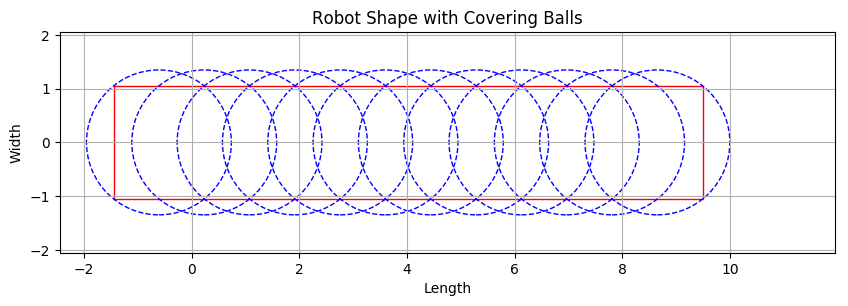

In [47]:
# Plotting the robot and the balls
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the robot as a rectangle
rectangle = plt.Rectangle((-offset_zoom[0], -rwidth_zoom / 2), rlength_zoom, rwidth_zoom, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rectangle)

# Plot the balls
for position in ball_positions:
    circle = plt.Circle(position, ball_radius, color='b', fill=False, linestyle='--')
    ax.add_artist(circle)

# Set limits and labels
ax.set_xlim(-offset_zoom[0]-1, rlength_zoom + 1)
ax.set_ylim(-rwidth_zoom / 2 - 1, rwidth_zoom / 2 + 1)
ax.set_xlabel('Length')
ax.set_ylabel('Width')
ax.set_title('Robot Shape with Covering Balls')
ax.set_aspect('equal', 'box')
ax.grid(True)

plt.show()

### 1.2 Building the obstacles in the 3D space

In order to to compute the obstacles in the 3D space we first need the distance transform of thos obstacles in 2D

In [48]:
walls_dist_2D = ndimage.distance_transform_edt(np.logical_not(walls),sampling=dx)

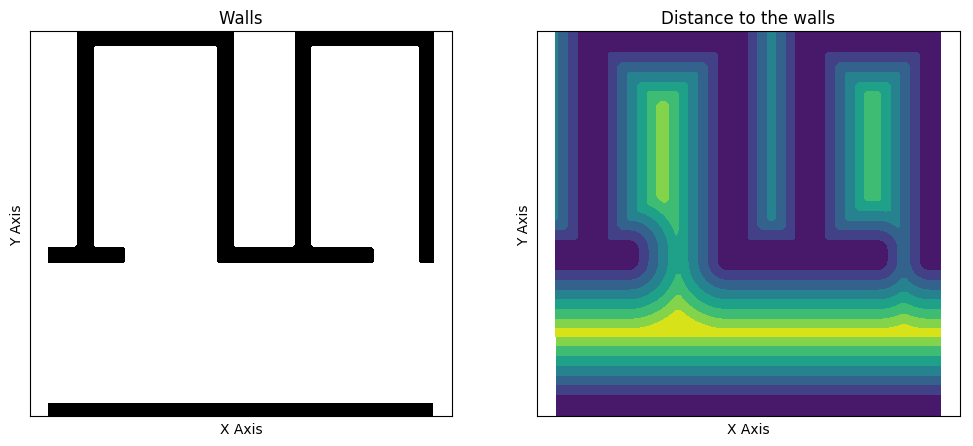

In [49]:
plt.figure(figsize=(12,5));
plt.subplot(1,2,1); plt.axis('equal'); plt.title("Walls");
plt.axis('equal')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.xticks([]) 
plt.yticks([]) 
plt.contourf(*X,walls,colors=['white','black'],levels=1);
plt.subplot(1,2,2); plt.axis('equal'); plt.title("Distance to the walls");
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.xticks([]) 
plt.yticks([]) 
plt.contourf(*X,walls_dist_2D);

For each balls the position of obstcales are calculated put together

In [50]:
combined_walls = np.zeros((Nθ,Nx,Ny))
# For each ball position in the calculated ball positions
for i in ball_positions:
    # Calculate the shifted obstacles for each orientation θ
    # The 2D distance map of the obstacles is shifted according to the ball's position and orientation θ
    walls3 = [ndimage.shift(walls_dist_2D, -i[0] * unitvec(θ) / dx, order=1) for θ in Θ]
    
    # For each shifted distance map, check if the distance is less than or equal to the ball's radius
    # If true, it means the ball collides with the obstacle
    walls3 = [np.logical_or(walls_dist_2D <= ball_radius, w <= ball_radius) for w in walls3]

    # Add the shifted and combined obstacles to `combined_walls`
    # This accumulates the obstacles for all ball positions and orientations
    combined_walls += walls3

# After processing all ball positions and orientations, stack the results along a new axis
# Create a 3D array where each "slice" corresponds to an orientation θ
# Converts the array to a boolean type to indicate the presence (True) or absence (False) of obstacles
walls3 = np.stack(combined_walls, axis=-1).astype(bool)

The three dimensional boolean array `walls3` indicates if the vehicle intersects the walls:
- for any position $(x,y)$ of the reference point.
- for any orientation $\theta$ of the vehicle.

We next compute the distance from these pseudo-walls, which will be used to favor trajectories remaining in a safe zone.

In [51]:
walls3_dist = ndimage.distance_transform_edt(np.logical_not(walls3),(dx,dy,1e10)) # Distance along spatial dims only

# To avoid deviation in open paces we can saturate the distance
walls3_dist_saturated = np.minimum(ndimage.distance_transform_edt(np.logical_not(walls3),(dx,dx,1e10)),0.5*rlength_zoom) # Distance along spatial dims only

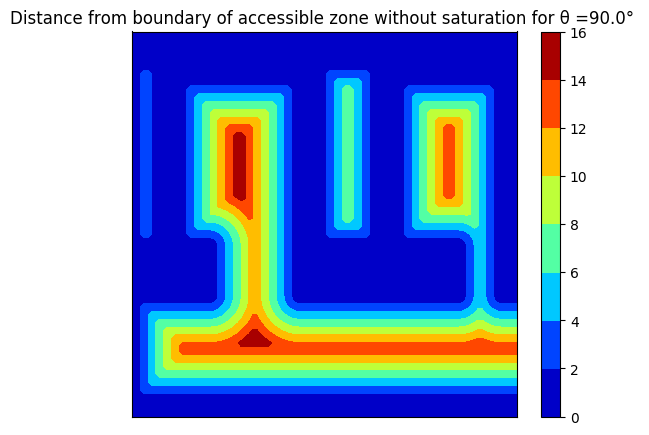

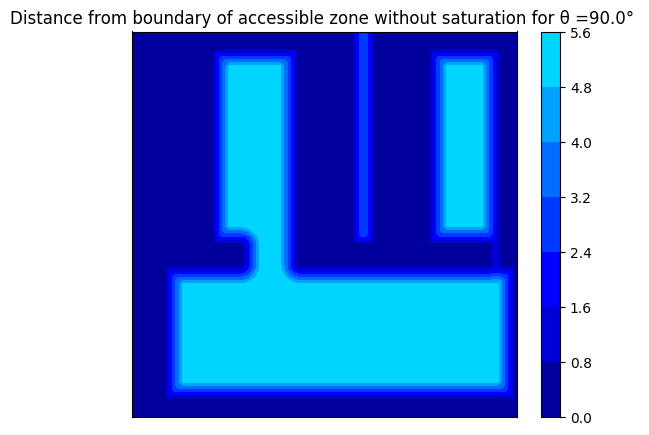

In [52]:
iθ = 25# Orientation of the vehicle
θ = Θ[iθ]  # Orientation angle

# Determine the combined range for color scale
min_val = min(walls3_dist[:,:,iθ].min(), walls3_dist_saturated[:,:,iθ].min())
max_val = max(walls3_dist[:,:,iθ].max(), walls3_dist_saturated[:,:,iθ].max())

plt.figure(figsize=(6.2, 5))

# First plot
# plt.subplot(1, 2, 1)
plt.axis('equal')
plt.xticks([])  # Remove x-axis tick marks and labels
plt.yticks([])  # Remove y-axis tick marks and labels
plt.title(f"Distance from boundary of accessible zone without saturation for θ ={iθ/Nθ *360}° ")
plt.contourf(*X, walls3_dist[:, :, iθ], vmin=min_val, vmax=max_val,cmap = "jet")
plt.colorbar()
plt.show()

plt.figure(figsize=(6.2, 5))
# Second subplot
#plt.subplot(1, 2, 2)
plt.axis('equal')
plt.xticks([])  # Remove x-axis tick marks and labels
plt.yticks([])  # Remove y-axis tick marks and labels
plt.title(f"Distance from boundary of accessible zone without saturation for θ ={iθ/Nθ *360}° ")
plt.contourf(*X, walls3_dist_saturated[:, :, 2*iθ], vmin=min_val, vmax=max_val,cmap = "jet")
plt.colorbar()

#plt.tight_layout()
plt.show()

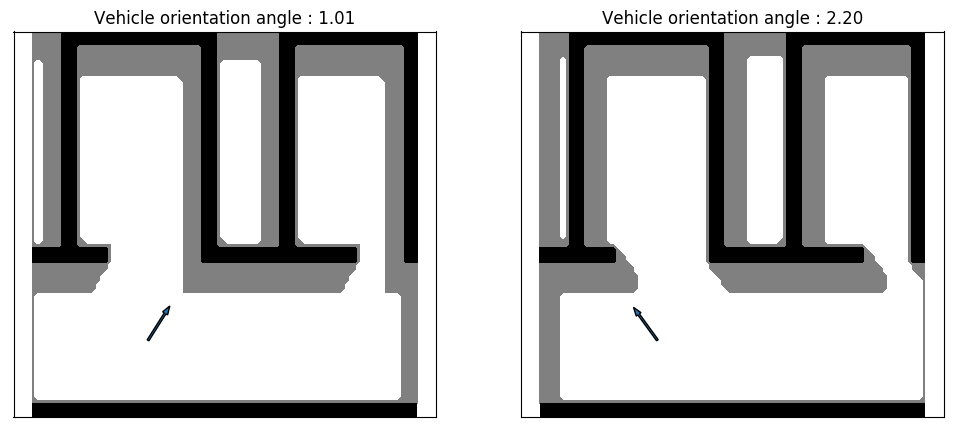

In [53]:
def show_vehicle(x,y,θ,**kwargs):
    """Shows an arrow from the center of the """
    offset_θ = offset.dot(np.array([[np.cos(θ),np.sin(θ)],[-np.sin(θ),np.cos(θ)]]))
    c,s = rlength_zoom*unitvec(θ)-offset_θ
    plt.arrow(x-offset_θ[0],y-offset_θ[1],c,s,width=0.5,length_includes_head=True,**kwargs)
plt.figure(figsize=(12,5))

vehicle_pos = [30, 20]
for i,iθ in enumerate([16,35]):
    θ=Θ[iθ]; plt.subplot(1,2,i+1); plt.axis('equal')
    plt.contourf(*X,walls.astype(int)+walls3[:,:,iθ],colors=['white','gray','black'],levels=2); plt.axis('equal');
    show_vehicle(*vehicle_pos,θ)
    plt.xticks([])  
    plt.yticks([])  
    plt.title(f"Vehicle orientation angle : {θ:.2f}")

## 2.Modelling the robot's motion

Our robot is a 4WS robot with limited steering capabilities. Hence loacally only certain movment in the configuration space are possible. 

Those movement are dicted by the kinematic model of the vehicle define as follow :

In [54]:
ψ_max = 0.5 #steering capabilties of the rear axle
ϕ_max = 0.5 #steering capabilties of the front axle

def Four_Wheel_Steering_kinematic(q,ψ,ϕ,τ,wheelbase):
    """
    Apply the 4WS kinmatic model on the configuration q
    Input : 
     - q : (x,y,θ) the current configuration
     - ψ : the steering of the rear wheels
     - ϕ : the steering of the front wheels
     - τ : the speed
     - wheelbase : the distance between the front and the rear axle
    """
    q1 = [0,0,0]
    q1[0] = q[0]+τ*np.cos(q[2]+ψ)
    q1[1] = q[1]+τ*np.sin(q[2]+ψ)
    q1[2] = q[2]+τ*np.cos(ϕ)*(np.tan(ϕ)-np.tan(ψ))/wheelbase
    return q1

We can now determine Tissot's indicatrix for this model 

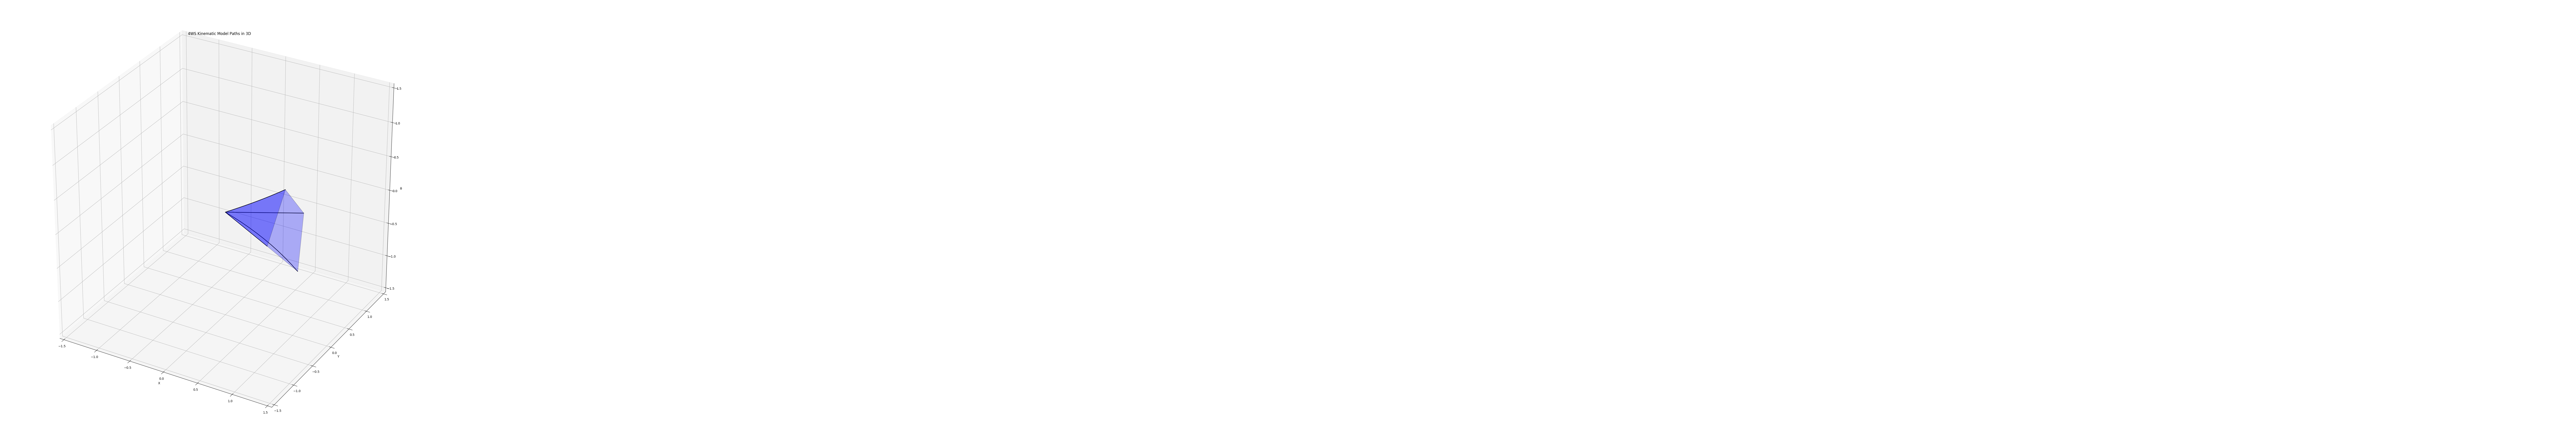

In [55]:
steering_back = [ϕ_max,-ϕ_max]
steering_front = [ψ_max,-ψ_max]
τ=0.1
length = 1
paths=[]
#Calculate the four extrem conditions
for ϕ in steering_back:
    for ψ in steering_front:
        q=[0,0,0]
        path=[q]
        for i in range(int(length/τ)):
            q = Four_Wheel_Steering_kinematic(q,ψ,ϕ,τ,wheelbase)
            path.append(q)
        paths.append(path)

        
# Plotting
fig = plt.figure(figsize=(25, 25), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1.5, 1.5)  
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

for i in range(0,len(paths)-1,2):
    edge1 = np.array(paths[i % len(paths)])
    edge2 = np.array(paths[(i+1)  % len(paths)])
    vertices = np.column_stack([edge1[:,0], edge1[:,1], edge1[:,2]])
    vertices = np.row_stack([vertices, np.flip(np.column_stack([edge2[:,0], edge2[:,1], edge2[:,2]]), axis=0)])
    poly = Poly3DCollection([vertices], alpha=0.3)
    poly.set_facecolor('blue')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)


for i in range(0,len(paths),3):
    edge1 = np.array(paths[i % len(paths)])
    edge2 = np.array(paths[(i + 2) % len(paths)])
    vertices = np.column_stack([edge1[:,0], edge1[:,1], edge1[:,2]])
    vertices = np.row_stack([vertices, np.flip(np.column_stack([edge2[:,0], edge2[:,1], edge2[:,2]]), axis=0)])
    poly = Poly3DCollection([vertices], alpha=0.3)
    poly.set_facecolor('blue')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)

# Plot each path
for path in paths:
    x = [point[0] for point in path]
    y = [point[1] for point in path]
    z = [point[2] for point in path]
    ax.plot(x, y, z,c='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('θ')
ax.set_title('4WS Kinematic Model Paths in 3D')
plt.show()

(We recommand running the code with `%matplotlib` for better visualization)

A core element of State-HFM is the state system. This aims to manage the different modes of operation and achieve more human like trajectories. First let's use a state system when the robot has access to all his kinematic capabilities all the time. We present three versions, one with only forward motion, one with only backward motion and one with both forward and backward motion enable :

In [56]:
def Four_WS_back(θ,wheel_base,ψ_max = 0.5,ϕ_max=0.5):
    """Control for 4WS vehicle with only backward motion"""
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    return xp.array([
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])[...,np.newaxis]

def Four_WS_front(θ,wheel_base,ψ_max = 0.5,ϕ_max=0.5):
    """Control for 4WS vehicle with only forward motion"""
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    return xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])[...,np.newaxis]
def Four_WS_omni(θ,wheel_base,ψ_max = 0.5,ϕ_max=0.5):
    """Control for 4WS vehicle with both frontward and backward motion"""
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    return xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])[...,np.newaxis]

After that we can describe a more complex state system. There are two “navigation” states, forward and backward, that uses the kinematic capability of a 2WS vehicle. There is a final state “maneuver” that uses the full ability of the 4WS. The transition to go in a “navigation” is unitary and exist only to deter the robot to change state without reason. The cost to go in the “maneuver” state is bigger because this state should only be used in difficult situation. The “navigation” states have three vectors in their control set, corresponding to turning right, turning left and going forward. The “going forward” vector has a bigger norm because we prefer that the robot just go forward in a straight line if possible. The “maneuver” have four vectors corresponding to each combination of the extreme values of steering for forward and backward axle. The vectors of this state are also of lesser norm compare to the others. This is also a way to avoid the use of this state if not necessary.

In [57]:
def Four_WS_complex_state(θ, wheel_base, rev_ratio=1, ϕ_max=0.5, ψ_max=0.5 ):
    """
    More comlex control with three states coresponding to navigation forward, navigation backward and manouver
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    nav_forward = 1.5*xp.array([
        (np.cos(θ),np.sin(θ),np.tan(ϕ_max) / (wheel_base * one)),
        (np.cos(θ),np.sin(θ),np.tan(-ϕ_max) / (wheel_base * one)),
        (2*np.cos(Θ),2*np.sin(Θ),zero),
        (zero,zero,zero),
        (zero,zero,zero),
        (zero,zero,zero),
        (zero,zero,zero),
        (zero,zero,zero)
    ])
    manouver = 0.5*xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one)
    ])
    nav_backward=-rev_ratio*marche_av_2ws #rev_ratio help adjust a potential preference between backward and forward motion
    
    return np.stack((nav_forward,manouver,nav_backward),axis=-1)

Finally we also implement a equivalent state system but for a 2WS robot:

In [58]:
def Two_WS_complex_state(θ, wheel_base, rev_ratio=1, ϕ_max=0.5, ψ_max=0 ):
    """
    More comlex control with three states coresponding to navigation forward, navigation backward and manouver
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    nav_forward = 1.5*xp.array([
        (np.cos(θ),np.sin(θ),np.tan(ϕ_max) / (wheel_base * one)),
        (np.cos(θ),np.sin(θ),np.tan(-ϕ_max) / (wheel_base * one)),
        (2*np.cos(Θ),2*np.sin(Θ),zero),
        (zero,zero,zero),
        (zero,zero,zero),
        (zero,zero,zero),
        (zero,zero,zero),
        (zero,zero,zero)
    ])
    manouver = 0.5*xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one)
    ])
    nav_backward=-rev_ratio*marche_av_2ws #rev_ratio help adjust a potential preference between backward and forward motion
    
    return np.stack((nav_forward,manouver,nav_backward),axis=-1)

## 3.Running the solver

In [59]:
hfmIn=None
hfmOut=None

In [60]:
hfmIn0 = Eikonal.dictIn({
    'model':'DubinsState4',
    'seed':[30,70,np.pi/2,0], # Compute the paths from a single seed point ...
    'tips':[[90,5,np.pi,0],[90,80,np.pi,0],[5,20,0,0]], # ... to three tips points.
    'origin':(0,0, 0,-0.5),
    'gridScales':(dx,dy, 2*np.pi/Nθ,1),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x A
    'exportActiveNeighs':True,
    'exportValues':True,
    'verbosity' : 1,
})

In [81]:
def run_controls(hfmIn, controls, fm2=1., saturation=0, state_transition_costs=5, verbosity=1, **kwargs):
    """
    Run the eikonal solver with the specified controls and display the results.
    - fm2 : penalize paths which come close to the walls, following the fast-marching square method.
    - saturation : uses the saturated distance map to avoid huge deviation in open spaces
    """
    hfmIn['controls'] = controls
    nstates = hfmIn['controls'].shape[-1]
    hfmIn['state_transition_costs'] = state_transition_costs * np.ones((nstates, nstates))
    hfmIn['dims'] = (Nx, Ny, Nθ, nstates)

    # The chosen speed function which proportional to the distance to the walls.
    # Important note : the speed function must not vanish
    if saturation:
        hfmIn['speed'] = np.broadcast_to(1 + fm2 * xp.array(walls3_dist_saturated)[:, :, :, np.newaxis], hfmIn.shape)
    else:
        hfmIn['speed'] = np.broadcast_to(1 + fm2 * xp.array(walls3_dist)[:, :, :, np.newaxis], hfmIn.shape)

    hfmIn['walls'] = np.broadcast_to(xp.array(walls3[:, :, :, np.newaxis]), hfmIn.shape)
    hfmIn.update(verbosity=verbosity, **kwargs)

    hfmOut = hfmIn.Run()

    # Plotting the base map
    base_map = plt.figure()
    plt.axis('equal')
    plt.xticks([])  # Remove x-axis tick marks and labels
    plt.yticks([])  # Remove y-axis tick marks and labels
    plt.contourf(*X, walls, colors=['white', 'black'])

    show_vehicle(*hfmIn0['seed'][:3].get(), color='blue')
    for i, tip in enumerate(hfmIn0['tips']):
        show_vehicle(*tip[:3].get(), color='red')
        plt.text(*tip[:2], i)
    

    
    #plt.xticks([])  # Remove x-axis tick marks and labels
    #plt.yticks([])  # Remove y-axis tick marks and labels

    #plt.contourf(*X,walls.astype(int)+(walls_dist<vehicle_radius),colors=['white','gray','black'],levels=2)
    plt.pcolormesh(*X,walls,cmap='binary')

    show_vehicle(*hfmIn0['seed'][:3].get(), color='blue')

    for i, tip in enumerate(hfmIn0['tips']):
        show_vehicle(*tip[:3].get(), color='red')
        plt.text(*tip[:2], i)

    for i, geo in enumerate(hfmOut['geodesics']):
        plt.plot(geo[0], geo[1], label=f"rear {i}",c='b')
        plt.plot(geo[0] + wheelbase_zoom * np.cos(geo[2]), geo[1] + wheelbase_zoom * np.sin(geo[2]), linestyle=':', label=f"front {i}")
        geo[2] = geo[2] + np.pi
        draw_bot(geo, 10, zoom_factor, np.array([rlength, rwidth]), offset, wheelbase)

    plt.show()  # Display the figure for the current geodesic

    return hfmIn, hfmOut

In [82]:
zoom_factor

3

In [88]:
hfmIn, hfmOut = run_controls(hfmIn0.copy(),Four_WS_back(Θ,wheelbase_zoom),verbosity=1,fm2=0)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.23465633392333984 seconds, and 216 iterations.
Post-Processing
3 3.649 0.7
3
[1.4535 0.    ]
3 [3.649 0.7  ] [10.947  2.1  ]
[10.947  2.1  ]
[9.4935, 1.4535, 1.0499999999999998, 1.0499999999999998]
[(-9.4935-1.0499999999999998j), (-9.4935+1.0499999999999998j), (1.4535-1.0499999999999998j), (1.4535+1.0499999999999998j)]
3 3.649 0.7
3
[1.4535 0.    ]
3 [3.649 0.7  ] [10.947  2.1  ]
[10.947  2.1  ]
[9.4935, 1.4535, 1.0499999999999998, 1.0499999999999998]
[(-9.4935-1.0499999999999998j), (-9.4935+1.0499999999999998j), (1.4535-1.0499999999999998j), (1.4535+1.0499999999999998j)]
3 3.649 0.7
3
[1.4535 0.    ]
3 [3.649 0.7  ] [10.947  2.1  ]
[10.947  2.1  ]
[9.4935, 1.4535, 1.0499999999999998, 1.0499999999999998]
[(-9.4935-1.0499999999999998j), (-9.4935+1.0499999999999998j), (1.4535-1.049999999999

In [87]:
%matplotlib

Using matplotlib backend: TkAgg


In [1]:
import sys
import os
# Obtenir le répertoire de travail actuel
repertoire_actuel = os.getcwd()

# Construire le chemin relatif vers le répertoire contenant plot_env.py
chemin_vers_plot_env = os.path.join(repertoire_actuel, 'bench-mr', 'python')

# Ajouter ce chemin à sys.path
sys.path.append(chemin_vers_plot_env)
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
from copy import deepcopy
from plot_env import plot_env
import json
from plot_env import plot_env, plot_env_options
from plot_trajectory import plot_trajectory, plot_nodes, plot_trajectory_options
from color import get_color, get_colors
import matplotlib.pyplot as plt
from mpb import MPB, MultipleMPB
from trajectory import visualize
from plot_stats import plot_planner_stats, plot_smoother_stats
from definitions import steer_functions, robot_models, planner_names
%config InlineBackend.figure_format='retina'
import os

from scipy import ndimage

In [2]:
from agd import Eikonal 
from agd import AutomaticDifferentiation as ad
from agd import Plotting
import time
import subprocess

In [3]:
import numpy as np; xp = np
from matplotlib import pyplot as plt

try :import cupy
except ModuleNotFoundError: raise ad.DeliberateNotebookError("A cuda enabled gpu is required for this notebook")

xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .


In [4]:
def create_mpb(planner : str, extend_function : str, planning_time):
    zoom_factor = 4.
    mpb = MPB()
    #mpb["ompl.seed"] = np.random.randint(255)
    mpb["ompl.seed"] = 5
    mpb["max_planning_time"] = planning_time
    mpb.set_planners([planner])
    #mpb.set_robot_models_functions(['kinematic_car'])
    mpb.set_steer_functions([extend_function])
    mpb["forwardpropagation.car_length"] = 1.38*zoom_factor
    mpb["forwardpropagation.car_turning_radius"] = zoom_factor*1.38/(np.tan(0.5))
    mpb["steer.car_turning_radius"] = zoom_factor*1.38/(np.tan(0.5))
    mpb["steer.allow_backward_motion"] = True
    mpb.set_corridor_grid_env(200, 200, branches=100, radius=8)
    mpb["env.collision.collision_model"] = 1
    current_dir = os.path.abspath(os.getcwd())
    bot_path = os.path.join(current_dir, "bot.svg")
    # map_path = os.path.join(current_dir, "maze.png")
    # map_path = os.path.join(current_dir, "maze_corner_zoom.png")
    map_path = os.path.join(current_dir, "benoit_world_zoom.png")
    # map_path = os.path.join(current_dir, "shortcut.png")
    mpb.set_image_grid_env(map_path,desired_width=200,desired_height=200,occupancy_threshold=0.5)#120*120 for corner zoom
    mpb["env.collision.robot_shape_source"] = bot_path
    mpb.set_id('comparison_extend_function_%s_%s' % (planner, extend_function))
    mpb.set_smoothers(['grips',
                   'ompl_bspline',
                   'ompl_shortcut',
                   'ompl_simplify_max'])
    mpb.set_goal(160, 30, np.pi/2) #benoit_world
    mpb.set_start(130, 140, 0*np.pi/2) #benoit_world
    
    # mpb.set_goal(25*4,200-18*4, 3*np.pi/2)
    # mpb.set_goal(175,175, np.pi/2)
    # mpb.set_goal(75,75, 0*np.pi/2) #maze
    # mpb.set_start(25,12, 0*np.pi/2) #maze
    # mpb.set_goal(94,60, 1*np.pi/2) #maze zoom
    # mpb.set_start(25,25, 0*np.pi/2) #maze zoom
    # mpb.set_goal(175,150, 3*np.pi/2) #shortcut
    # mpb.set_start(7,180, 0*np.pi/2) #shortcut
    
    
    return mpb

Available memory: 33.90 GB, limiting each MPB process to 31.2% usage (10.59 GB).
Creating pool of 4 processes.
Running MPB with ID comparison_extend_function_rrt_reeds_shepp (log file at RC/comparison_extend_function_rrt_reeds_shepp.log)...Running MPB with ID comparison_extend_function_rrt_star_reeds_shepp (log file at RC/comparison_extend_function_rrt_star_reeds_shepp.log)...Running MPB with ID comparison_extend_function_sst_reeds_shepp (log file at RC/comparison_extend_function_sst_reeds_shepp.log)...Running MPB with ID comparison_extend_function_informed_rrt_star_reeds_shepp (log file at RC/comparison_extend_function_informed_rrt_star_reeds_shepp.log)...





comparison_extend_function_informed_rrt_star_reeds_shepp:   0%|          | 0/5 [00:00<?, ?it/s]

comparison_extend_function_sst_reeds_shepp:   0%|          | 0/5 [00:00<?, ?it/s]

comparison_extend_function_rrt_reeds_shepp:   0%|          | 0/5 [00:00<?, ?it/s]

comparison_extend_function_rrt_star_reeds_shepp:   0%|          | 0/5 [00:00<?, ?it/s]

Benchmark 2 (comparison_extend_function_rrt_star_reeds_shepp) finished successfully.
Benchmark 3 (comparison_extend_function_informed_rrt_star_reeds_shepp) finished successfully.
Benchmark 0 (comparison_extend_function_rrt_reeds_shepp) finished successfully.
Benchmark 1 (comparison_extend_function_sst_reeds_shepp) finished successfully.
All benchmarks succeeded.
Successfully merged [RC/comparison_extend_function_rrt_reeds_shepp_results.json, RC/comparison_extend_function_sst_reeds_shepp_results.json, RC/comparison_extend_function_rrt_star_reeds_shepp_results.json, RC/comparison_extend_function_informed_rrt_star_reeds_shepp_results.json] into comparison_extend_functions_RC.json.


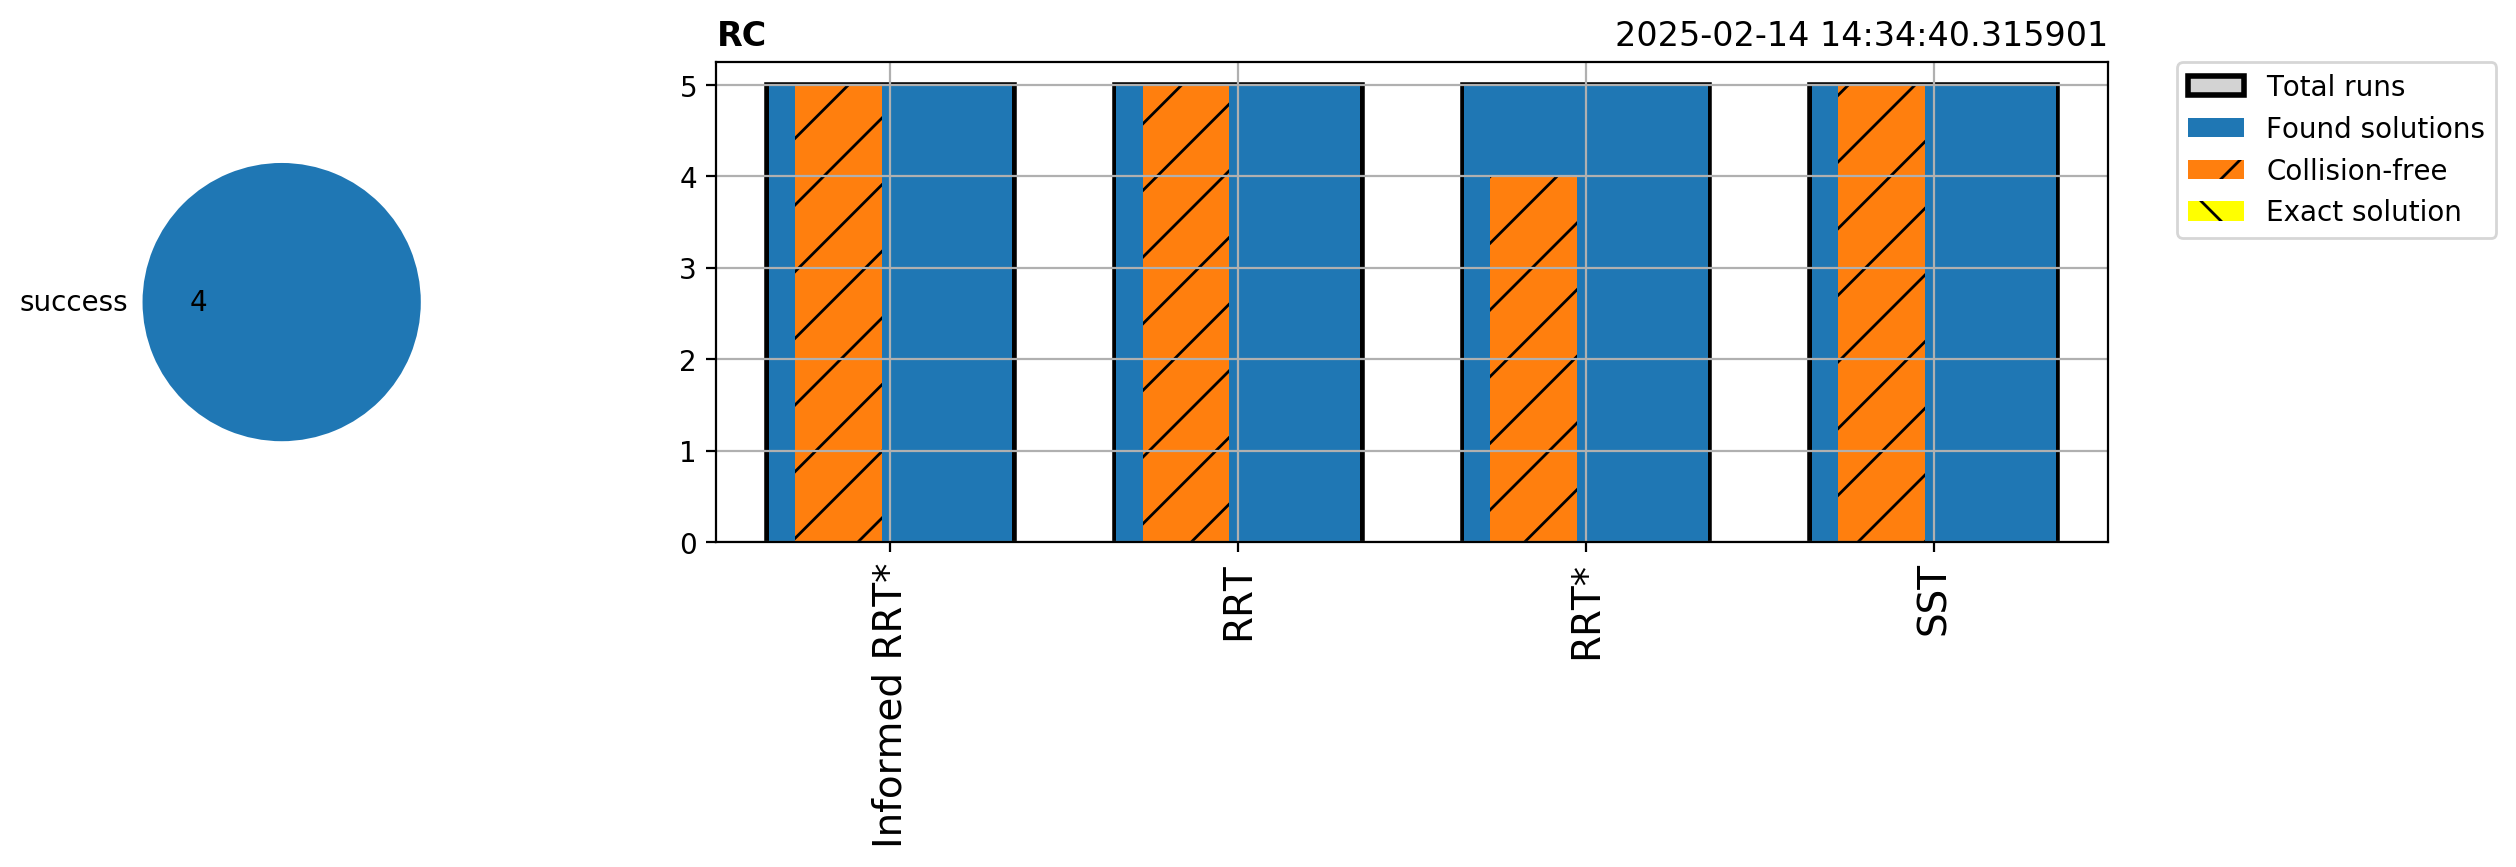

In [5]:
pool = MultipleMPB()
for planner in ['rrt','sst','rrt_star','informed_rrt_star']:#, 'est','sbl', 'prm', 'sst', 'fmt', 'kpiece', 'pdst', 'stride', 'rrt_star', 'rrt_sharp', 'informed_rrt_star','prm_star','bfmt', 'cforest', 'spars', 'spars2']:#['rrt', 'est','sbl', 'prm', 'theta_star', 'sst', 'fmt', 'kpiece', 'pdst', 'stride', 'rrt_star', 'rrt_sharp', 'informed_rrt_star','prm_star','bfmt', 'cforest', 'spars', 'spars2']:#['fpest', 'fprrt', 'fpsst', 'fpkpiece']:
    #if planner == 'rrt' : 
    pool.benchmarks.append(create_mpb(planner, 'reeds_shepp', 5))
pool.run_parallel(runs=5, id='RC', show_plot=True)
pool.merge('comparison_extend_functions_RC.json')
# pool = MultipleMPB()
# for planner in ['rrt']:
#     pool.benchmarks.append(create_mpb(planner, 'hc_reeds_shepp', 30))
# pool.run_parallel(runs=5, id='HC_RC', show_plot=True)
# pool.merge('comparison_extend_functions_HC_RC.json')
# pool = MultipleMPB()
# for planner in ['rrt']:
#     pool.benchmarks.append(create_mpb(planner, 'cc_reeds_shepp', 30))
# pool.run_parallel(runs=5, id='CC_RC', show_plot=True)
# pool.merge('comparison_extend_functions_CC_RC.json')

Visualizing comparison_extend_functions_RC.json


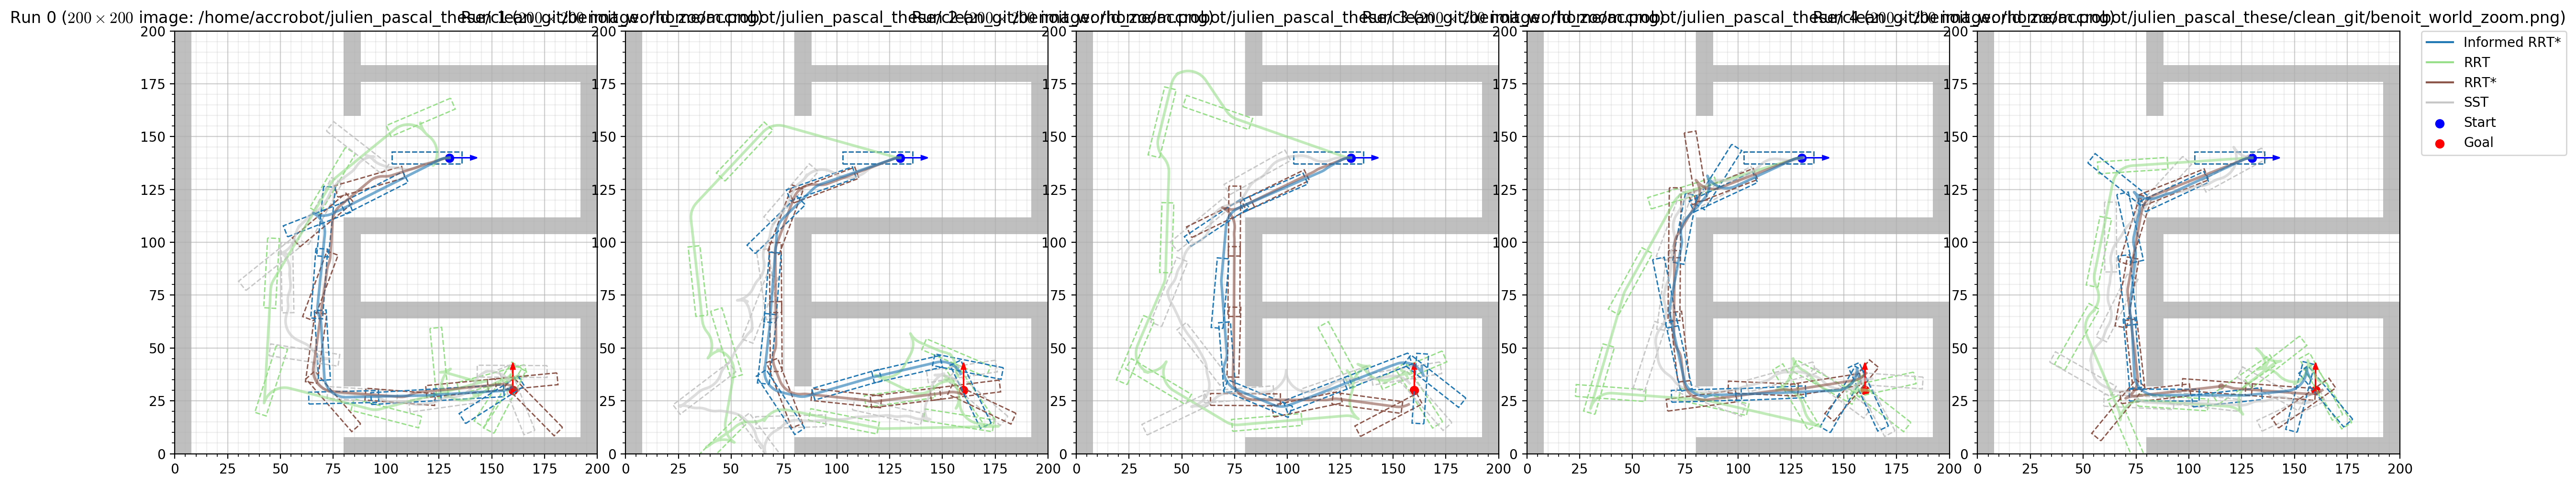

In [6]:
visualize('comparison_extend_functions_RC.json', plot_every_nth_polygon=60,draw_start_goal_thetas=True)
# visualize('comparison_extend_functions_HC_RC.json', plot_every_nth_polygon=160,show_smoother=True,draw_start_goal_thetas=True)
# visualize('comparison_extend_functions_CC_RC.json', plot_every_nth_polygon=160,show_smoother=True,draw_start_goal_thetas=True)

Visualizing comparison_extend_functions_RC.json...
Ignoring the following planner(s): kbitstar
Saved RC_RRT_metrics.pdf.


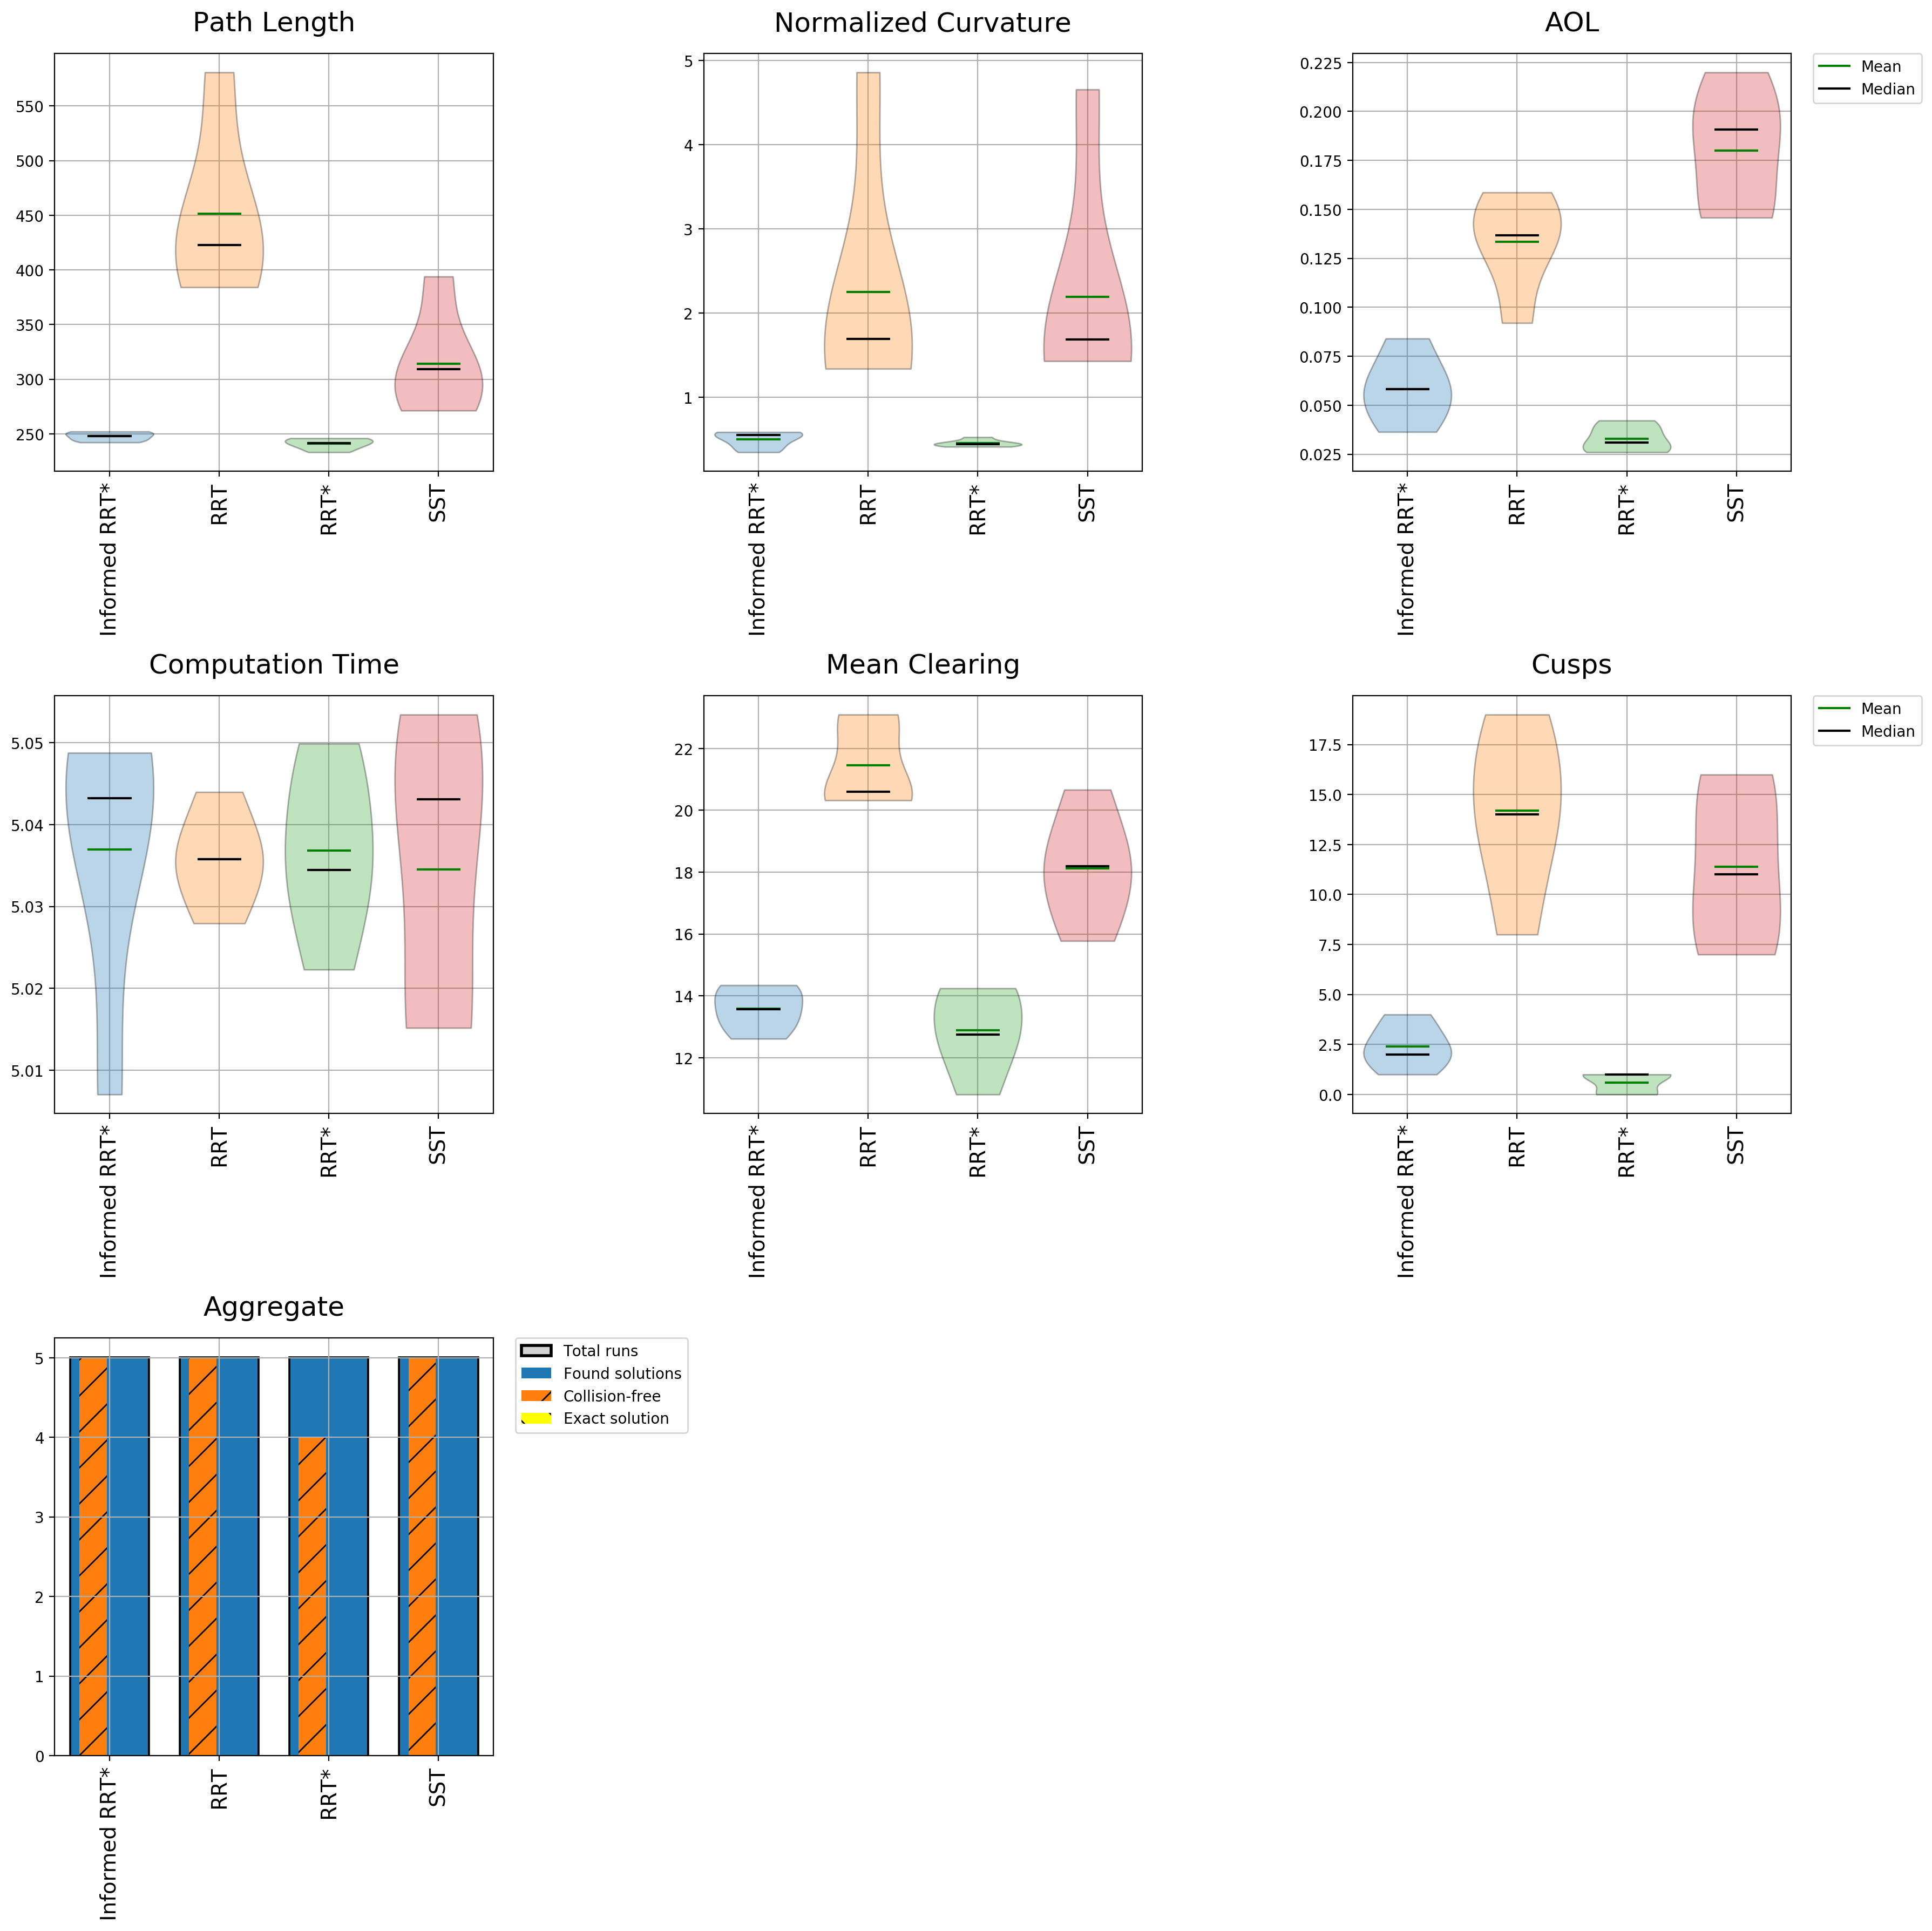

In [7]:
plot_planner_stats('comparison_extend_functions_RC.json', num_colors=10, ignore_planners="kBITstar",save_file = "RC_RRT_metrics.pdf")
# plot_planner_stats('comparison_extend_functions_HC_RC.json', num_colors=10, ignore_planners="kBITstar",save_file = "HC_RC_RRT_metrics.pdf")
# plot_planner_stats('comparison_extend_functions_CC_RC.json', num_colors=10, ignore_planners="kBITstar",save_file = "CC_RC_RRT_metrics.pdf")

In [8]:
# pool = MultipleMPB()
# for planner in ['rrt', 'est','sbl', 'prm', 'sst', 'fmt', 'kpiece', 'pdst', 'stride', 'rrt_star', 'rrt_sharp', 'informed_rrt_star','prm_star','bfmt', 'cforest', 'spars', 'spars2']:#['rrt', 'est','sbl', 'prm', 'theta_star', 'sst', 'fmt', 'kpiece', 'pdst', 'stride', 'rrt_star', 'rrt_sharp', 'informed_rrt_star','prm_star','bfmt', 'cforest', 'spars', 'spars2']:#['fpest', 'fprrt', 'fpsst', 'fpkpiece']:
#     #if planner == 'rrt' : 
#     pool.benchmarks.append(create_mpb(planner, 'reeds_shepp', 15))
#     #pool.benchmarks.append(create_mpb(planner, 'hc_reeds_shepp', 15))
#     #pool.benchmarks.append(create_mpb(planner, 'cc_reeds_shepp', 15))
# # for planner in ['fpest', 'fprrt', 'fpsst', 'fpkpiece']:
# #     mpb = MPB()
# #     mpb["max_planning_time"] = 15
# #     mpb.set_planners([planner])
# #     mpb.set_robot_models_functions(['kinematic_car'])
# #     mpb["forwardpropagation.car_length"] = 1.38*8
# #     mpb["forwardpropagation.car_turning_radius"] = 8*1.38/(np.tan(0.5))
# #     current_dir = os.path.abspath(os.getcwd())
# #     bot_path = os.path.join(current_dir, "bot_zoom.svg")
# #     map_path = os.path.join(current_dir, "benoit_world_zoom.png")
# #     mpb.set_image_grid_env(map_path,desired_width=200,desired_height=200,occupancy_threshold=0.5)
# #     mpb["env.collision.robot_shape_source"] = bot_path
# #     mpb["ompl.seed"] = 1
# #     mpb.set_goal(160, 30, np.pi/2)
# #     mpb.set_start(130, 140, 0*np.pi/2)
# #     mpb.set_id('comparison_extend_function_%s_%s' % (planner, 'kinematic_car'))
# #     pool.benchmarks.append(mpb)
# pool.run_parallel(runs=10, id='comparison_extend_functions', show_plot=True)
# pool.merge('comparison_extend_functions.json')

In [9]:
# visualize('comparison_extend_functions.json', plot_every_nth_polygon=160,show_smoother=True,draw_start_goal_thetas=True)

In [10]:
# plot_planner_stats('comparison_extend_functions.json', num_colors=10, ignore_planners="kBITstar",save_file = "Dubins_RRT_metrics.pdf")

In [11]:
# pool = MultipleMPB()
# # for planner in ['rrt', 'est','sbl', 'prm', 'sst', 'fmt', 'kpiece', 'pdst', 'stride', 'rrt_star', 'rrt_sharp', 'informed_rrt_star','prm_star','bfmt', 'cforest', 'spars', 'spars2']:#['rrt', 'est','sbl', 'prm', 'theta_star', 'sst', 'fmt', 'kpiece', 'pdst', 'stride', 'rrt_star', 'rrt_sharp', 'informed_rrt_star','prm_star','bfmt', 'cforest', 'spars', 'spars2']:#['fpest', 'fprrt', 'fpsst', 'fpkpiece']:
# #     #if planner == 'rrt' : 
# #     pool.benchmarks.append(create_mpb(planner, 'reeds_shepp', 15))
#     #pool.benchmarks.append(create_mpb(planner, 'hc_reeds_shepp', 15))
#     #pool.benchmarks.append(create_mpb(planner, 'cc_reeds_shepp', 15))
# for planner in ['fpest', 'fprrt', 'fpsst', 'fpkpiece']:
#     mpb = MPB()
#     mpb["max_planning_time"] = 15
#     mpb.set_planners([planner])
#     mpb.set_robot_models_functions(['kinematic_car'])
#     mpb["forwardpropagation.car_length"] = 1.38*8
#     mpb["forwardpropagation.car_turning_radius"] = 8*1.38/(np.tan(0.5))
#     current_dir = os.path.abspath(os.getcwd())
#     bot_path = os.path.join(current_dir, "bot_zoom.svg")
#     map_path = os.path.join(current_dir, "benoit_world_zoom.png")
#     mpb.set_image_grid_env(map_path,desired_width=200,desired_height=200,occupancy_threshold=0.5)
#     mpb["env.collision.robot_shape_source"] = bot_path
#     mpb["ompl.seed"] = 1
#     mpb.set_goal(160, 30, np.pi/2)
#     mpb.set_start(130, 140, 0*np.pi/2)
#     mpb.set_id('comparison_extend_function_%s_%s' % (planner, 'kinematic_car'))
#     pool.benchmarks.append(mpb)
# pool.run_parallel(runs=10, id='comparison_extend_functions', show_plot=True)
# pool.merge('comparison_extend_functions.json')

In [12]:
# visualize('comparison_extend_functions.json', plot_every_nth_polygon=10000,show_smoother=True,draw_start_goal_thetas=True)

In [13]:
# plot_planner_stats('comparison_extend_functions.json', num_colors=10, ignore_planners="kBITstar",save_file = "Dubins_RRT_metrics.pdf")

In [14]:
# plot_smoother_stats('comparison_extend_functions.json',ignore_planners="kBITstar,Theta*,BFMT,SPARStwo")

In [15]:
# Nx = width # Number of points along the x-axis
# Ny = height
Nθ = 100 # Number of points along the angular dimension
Θ = np.linspace(0,2*np.pi,Nθ,endpoint=False)
zoom_factor = 8
rlength = 3.6490*zoom_factor #robot length in m
rwidth = 0.7*zoom_factor #robot width in m
balls_number = 12
walls3 = np.ones((Nθ,Nθ,Nθ))

In [16]:
def control_source(activeNeighs,ncontrols,control_default=np.nan,source_default=np.nan):
    """
    Returns the optimal control, or the source of the optimal jump, at each point reached 
    by the front.
    Input : 
     - activeNeighs : produced by the eikonal solver, with option 'exportActiveNeighs':True
     - ncontrols : number of controls of the model (needed in case of several states)
     - control default : when no control is used (jump to another state, or stationnary point)
     - jump default : when no jump is done (following a control vector, or stationnary point)
    Output : 
     - control : the index of the control used
     - source (only if several states) : the index of the source state of the jump
    """
    nstates = activeNeighs.shape[-1]
    ndim = activeNeighs.ndim
    decompdim = (ndim*(ndim-1))//2
    active = activeNeighs%(2**decompdim)
    stationnary = (active==0) # No control used. Seeds and non reachable points (e.g. inside walls)
    control = np.where(stationnary,control_default,activeNeighs//(2**decompdim)) 
    assert np.all(control[~stationnary]<ncontrols+(nstates>1))
    if nstates==1: return control # Model with a single state
    jump = (~stationnary) & (control==ncontrols) # Points where the optimal option is to jump to a different state
    source = np.log2(active).round().astype(int) # source of the jump
    source = np.where(jump,source + (source>=xp.arange(nstates)), source_default)
    return np.where(control==ncontrols,control_default,control),source

In [17]:
offset = np.array([-0.4845,0])*zoom_factor
def draw_bot(gamma,nb_pt = 10, fact = 1., bot_dim=[3.6490,0.7000] ,colors=['g','y','r']):
    """
    draw the figure of the robot nb_pt time spread regularly accross the path gamma.
    fact is a multiplicative factor to scale the robot
    colors are the colors of the first (not used), the intermidates, and the last figure of the robot
    """
    offset = np.array([0.4845,0])*fact
    rlength = bot_dim[0]-offset[0]#1.38
    rwidth = bot_dim[1]
    bot_dim = [rlength,offset[0],0.5*rwidth,0.5*rwidth]
    long_av = bot_dim[0]
    long_ar = bot_dim[1]
    larg_le = bot_dim[2]
    larg_ri = bot_dim[3]
    bot = [-long_av-larg_le*1j,-long_av+larg_ri*1j,long_ar-larg_le*1j,long_ar+larg_ri*1j]
    print(np.array(bot))
    pt = []
    #print(gamma)
    for i in range(len(gamma[0])):
        xx = bot[0]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        xy = bot[1]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        yx = bot[2]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        yy = bot[3]*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        lfcenter = (-bot_dim[0]/2.+bot_dim[2]*1j)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        rfcenter = (-bot_dim[0]/2.-bot_dim[3]*1j)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        fcenter = (-1.38*fact)*(np.cos(gamma[2,i])+np.sin(gamma[2,i])*1j)+gamma[0,i]+1j*gamma[1,i]
        pt.append([xx,yx,xy,yy,lfcenter,rfcenter,fcenter])
    pt = xp.array(pt)
    pt = pt.get()


    w=(np.linspace(0,len(gamma[0])-1,nb_pt)).astype(int)

    for c in w :
        plt.plot(np.real([pt[c,0],pt[c,1]]),np.imag([pt[c,0],pt[c,1]]),colors[1])
        plt.plot(np.real([pt[c,2],pt[c,3]]),np.imag([pt[c,2],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,1],pt[c,3]]),np.imag([pt[c,1],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,1],pt[c,3]]),np.imag([pt[c,1],pt[c,3]]),colors[1])
        plt.plot(np.real([pt[c,4],pt[c,5]]),np.imag([pt[c,4],pt[c,5]]),colors[1])
    if len(w)!= 0: 
        plt.plot(np.real([pt[-1,0],pt[-1,1]]),np.imag([pt[c,0],pt[c,1]]),colors[2])
        plt.plot(np.real([pt[-1,2],pt[-1,3]]),np.imag([pt[c,2],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,1],pt[-1,3]]),np.imag([pt[c,1],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,1],pt[-1,3]]),np.imag([pt[c,1],pt[c,3]]),colors[2])
        plt.plot(np.real([pt[-1,4],pt[-1,5]]),np.imag([pt[c,4],pt[c,5]]),colors[2])
        
        plt.plot(np.real([pt[0,0],pt[0,1]]),np.imag([pt[0,0],pt[0,1]]),colors[0])
        plt.plot(np.real([pt[0,2],pt[0,3]]),np.imag([pt[0,2],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,1],pt[0,3]]),np.imag([pt[0,1],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,1],pt[0,3]]),np.imag([pt[0,1],pt[0,3]]),colors[0])
        plt.plot(np.real([pt[0,4],pt[0,5]]),np.imag([pt[0,4],pt[0,5]]),colors[0])


In [18]:
data = json.load(open('comparison_extend_functions_RC.json', "r"))
def extract_env(run):
    map_string = run["environment"]["map"]
    width = run["environment"]["width"]
    height = len(map_string) // width
    walls = np.array([int(char) for char in map_string]).reshape(height, width).T
    
    Nx = width # Number of points along the x-axis
    Ny = height
    
    dx = walls.shape[0]/Nx # Distance between consecutive pixels, in original coordinates
    dy = walls.shape[1]/Ny
    walls = ndimage.zoom(walls.astype(float),1/dx,order=1)>0.5
    
    X = np.meshgrid(np.arange(walls.shape[0])*dx,np.arange(walls.shape[1])*dy,indexing='ij')
    walls_dist = ndimage.distance_transform_edt(np.logical_not(walls),sampling=dx)
    
    return walls,X,walls_dist,[dx,dy],[Nx,Ny]

walls,X,walls_dist,Dxy,Nxy = extract_env(data["runs"][0])

def unitvec(θ): return np.array([np.cos(θ),np.sin(θ)])
def calculate_balls_positions(rlenght,balls_number) : return np.array([(rlenght/(balls_number+1) * (i+1), 0) for i in range(balls_number)])
def calculate_min_radius(rwidth,x_ball_0): return np.sqrt((rwidth/2)**2+x_ball_0**2)

def build_3d(balls_number,walls_dist,Nxy,Dxy):
    combined_walls = np.zeros((Nθ,Nxy[0],Nxy[1]))
    
    
    start_time = time.time()
    ball_positions = calculate_balls_positions(rlength,balls_number)+ offset
    print(ball_positions)
    ball_radius = calculate_min_radius(rwidth,ball_positions[0][0])
    
    for i in ball_positions : 
        walls3 = [ndimage.shift(walls_dist,-i[0]*unitvec(θ)/Dxy[0],order=1) for θ in Θ]
        walls3 = [np.logical_or(walls_dist<ball_radius,w<ball_radius) for w in walls3]

        combined_walls+=walls3
        
    walls3 = np.stack(combined_walls,axis=-1).astype(bool)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"3d obstacles calculation time: {elapsed_time} seconds")
    
    start_time = time.time()
    
    walls3_dist = np.minimum(ndimage.distance_transform_edt(np.logical_not(walls3.copy()),(Dxy[0],Dxy[1],1e10)),2000*0.5*rlength*zoom_factor) # Distance along spatial dims only

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"3d obstacles distances time: {elapsed_time} seconds")
    
    start_time = time.time()
    
    walls3_dist_saturated = np.minimum(ndimage.distance_transform_edt(np.logical_not(walls3.copy()),(Dxy[0],Dxy[1],1e10)),0.5*rlength*zoom_factor) # Distance along spatial dims only
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"3d obstacles distances saturated time: {elapsed_time} seconds")
    
    
    return walls3, walls3_dist, walls3_dist_saturated

walls3, walls3_dist, walls3_dist_saturated = build_3d(balls_number, walls_dist,Nxy,Dxy)

[[-1.63046154  0.        ]
 [ 0.61507692  0.        ]
 [ 2.86061538  0.        ]
 [ 5.10615385  0.        ]
 [ 7.35169231  0.        ]
 [ 9.59723077  0.        ]
 [11.84276923  0.        ]
 [14.08830769  0.        ]
 [16.33384615  0.        ]
 [18.57938462  0.        ]
 [20.82492308  0.        ]
 [23.07046154  0.        ]]
3d obstacles calculation time: 1.149087905883789 seconds
3d obstacles distances time: 0.49123191833496094 seconds
3d obstacles distances saturated time: 0.4916110038757324 seconds


In [19]:
def show_vehicle(x,y,θ,**kwargs):
    """Shows an arrow from the center of the """
    offset_θ = offset.dot(np.array([[np.cos(θ),np.sin(θ)],[-np.sin(θ),np.cos(θ)]]))
    c,s = (rlength+offset[0])*unitvec(θ)-offset_θ
    # plt.scatter(x+ball_positions[0:11,0]*np.cos(θ)-ball_positions[0:11,1]*np.sin(θ),y+ball_positions[0:11,0]*np.sin(θ)+ball_positions[0:11,1]*np.cos(θ),
    #             28*ball_radius**2,color='lightblue')
    # print((x+ball_positions[:,0]*np.cos(θ)),(y+ball_positions[:,1])*np.sin(θ))
    # plt.scatter(x+c,y+s,28*vehicle_radius**2,color='lightblue')
    print(x,y,x-offset_θ[0], y-offset_θ[1])
    plt.arrow(x,y,c,s,width=0.5,length_includes_head=True,**kwargs)

In [20]:
def run_controls(hfmIn,controls,fm2=1.,saturation = 0,state_transition_costs=5,verbosity=1,**kwargs):
    """
    Run the eikonal solver with the specified controls and display the results.
    - fm2 : penalize paths which come close to the walls, following the fast-marching square method.
    """
    hfmIn['controls'] = controls
    nstates = hfmIn['controls'].shape[-1]
    hfmIn['state_transition_costs'] = state_transition_costs*np.ones((nstates,nstates))
    hfmIn['dims']=(Nx,Ny, Nθ,nstates)

    # The chosen speed function which proportional to the distance to the walls.
    # Important note : the speed function must not vanish
    if saturation : 
        hfmIn['speed'] = np.broadcast_to(1+fm2*xp.array(walls3_dist_saturated)[:,:,:,np.newaxis],hfmIn.shape)
    else : 
        # hfmIn['speed'] = np.broadcast_to(1+fm2*xp.array(map_dist)[:,:,:,np.newaxis],hfmIn.shape)
        hfmIn['speed'] = np.broadcast_to(1+fm2*xp.array(walls3_dist)[:,:,:,np.newaxis],hfmIn.shape)
    
    # hfmIn['speed'] = np.broadcast_to(1+xp.array(map_dist)[:,:,:,np.newaxis],hfmIn.shape)
    # hfmIn['cost'] = np.broadcast_to(1+fm2*xp.array(1/map_dist)[:,:,:,np.newaxis],hfmIn.shape)
    hfmIn['walls'] = np.broadcast_to(xp.array(walls3[:,:,:,np.newaxis]),hfmIn.shape)
    # hfmIn['walls'] = np.broadcast_to(xp.array(walls_obs[:,:,:,np.newaxis]),hfmIn.shape)
    hfmIn.update(verbosity=verbosity,**kwargs)
    
    hfmOut=hfmIn.Run()
    
    wheel_base = 1.38*zoom_factor
    plt.figure()
    plt.axis('equal')
    
    #plt.xticks([])  # Remove x-axis tick marks and labels
    #plt.yticks([])  # Remove y-axis tick marks and labels

    #plt.contourf(*X,walls.astype(int)+(walls_dist<vehicle_radius),colors=['white','gray','black'],levels=2)
    plt.pcolormesh(*X,walls,cmap='binary')

    show_vehicle(*hfmIn0['seed'][:3].get(), color='blue')

    for i, tip in enumerate(hfmIn0['tips']):
        show_vehicle(*tip[:3].get(), color='red')
        plt.text(*tip[:2], i)

    for i, geo in enumerate(hfmOut['geodesics']):
        plt.plot(geo[0], geo[1], label=f"rear {i}",c='b')
        plt.plot(geo[0] + wheel_base * np.cos(geo[2]), geo[1] + wheel_base * np.sin(geo[2]), linestyle=':', label=f"front {i}")
        cpgeo = geo.copy()
        cpgeo[2] = cpgeo[2] + np.pi
        draw_bot(cpgeo, int(len(geo[0])/60), zoom_factor, [rlength, rwidth])
        print([rlength, rwidth])
        for j in range(len(geo[0])):
            if walls3[int(geo[0,j]),int(geo[1,j]),np.argmin(np.abs(Θ - (float(geo[2,j])%(2*np.pi))))]:
                plt.scatter(geo[0,j],geo[1,j],c="r", zorder = 5)
        # plt.scatter(geo[0], geo[1],c=geo[3],zorder = 5)

    #plt.legend()  # Remove the legend

    plt.show()
    return hfmIn,hfmOut

In [21]:
def Dubins_Reduced_controls_2WS(θ, wheel_base, rev_ratio=1, ϕ_max=0.5, ψ_max=0.0 ):
    """
    Controls with two states to avoid spinning effects and 100 vectors with varying norms
    to have smooth curves and prefer straight line forward motion
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    marche_av_2ws = 1.5*xp.array([
        (np.cos(θ),np.sin(θ),np.tan(ϕ_max) / (wheel_base * one)),
        (np.cos(θ),np.sin(θ),np.tan(-ϕ_max) / (wheel_base * one)),
        (2*np.cos(Θ),2*np.sin(Θ),zero),
        (zero,zero,zero)
    ])
    maneuvre_4WS_av = 0.5*xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one)
    ])
    maneuvre_4WS_ar = 0.5*xp.array([
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])
    marche_ar_2ws=-rev_ratio*marche_av_2ws
    
    return np.stack((marche_av_2ws,maneuvre_4WS_av,maneuvre_4WS_ar,marche_ar_2ws),axis=-1)

def Dubins_Reduced_controls_4WS(θ, wheel_base, rev_ratio=1, ϕ_max=0.5, ψ_max=0.5 ):
    """
    Controls with two states to avoid spinning effects and 100 vectors with varying norms
    to have smooth curves and prefer straight line forward motion
    """
    zero, one = np.zeros_like(θ), np.ones_like(θ)
    marche_av_2ws = 1.5*xp.array([
        (np.cos(θ),np.sin(θ),np.tan(ϕ_max) / (wheel_base * one)),
        (np.cos(θ),np.sin(θ),np.tan(-ϕ_max) / (wheel_base * one)),
        (2*np.cos(Θ),2*np.sin(Θ),zero),
        (zero,zero,zero)
    ])
    maneuvre_4WS_av = 0.5*xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one)
    ])
    maneuvre_4WS_ar = 0.5*xp.array([
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-( np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-(-np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ-ψ_max),-np.sin(Θ-ψ_max),-( np.tan(ϕ_max)+np.tan(ψ_max))/wheel_base*one), 
        (-np.cos(Θ+ψ_max),-np.sin(Θ+ψ_max),-(-np.tan(ϕ_max)-np.tan(ψ_max))/wheel_base*one),
    ])
    marche_ar_2ws=-rev_ratio*marche_av_2ws
    
    return np.stack((marche_av_2ws,maneuvre_4WS_av,maneuvre_4WS_ar,marche_ar_2ws),axis=-1)

In [22]:
# %matplotlib

Run n° 1
[[-1.63046154  0.        ]
 [ 0.61507692  0.        ]
 [ 2.86061538  0.        ]
 [ 5.10615385  0.        ]
 [ 7.35169231  0.        ]
 [ 9.59723077  0.        ]
 [11.84276923  0.        ]
 [14.08830769  0.        ]
 [16.33384615  0.        ]
 [18.57938462  0.        ]
 [20.82492308  0.        ]
 [23.07046154  0.        ]]
3d obstacles calculation time: 1.148134708404541 seconds
3d obstacles distances time: 0.4848177433013916 seconds
3d obstacles distances saturated time: 0.4741806983947754 seconds
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 5.280975341796875 seconds, and 326 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


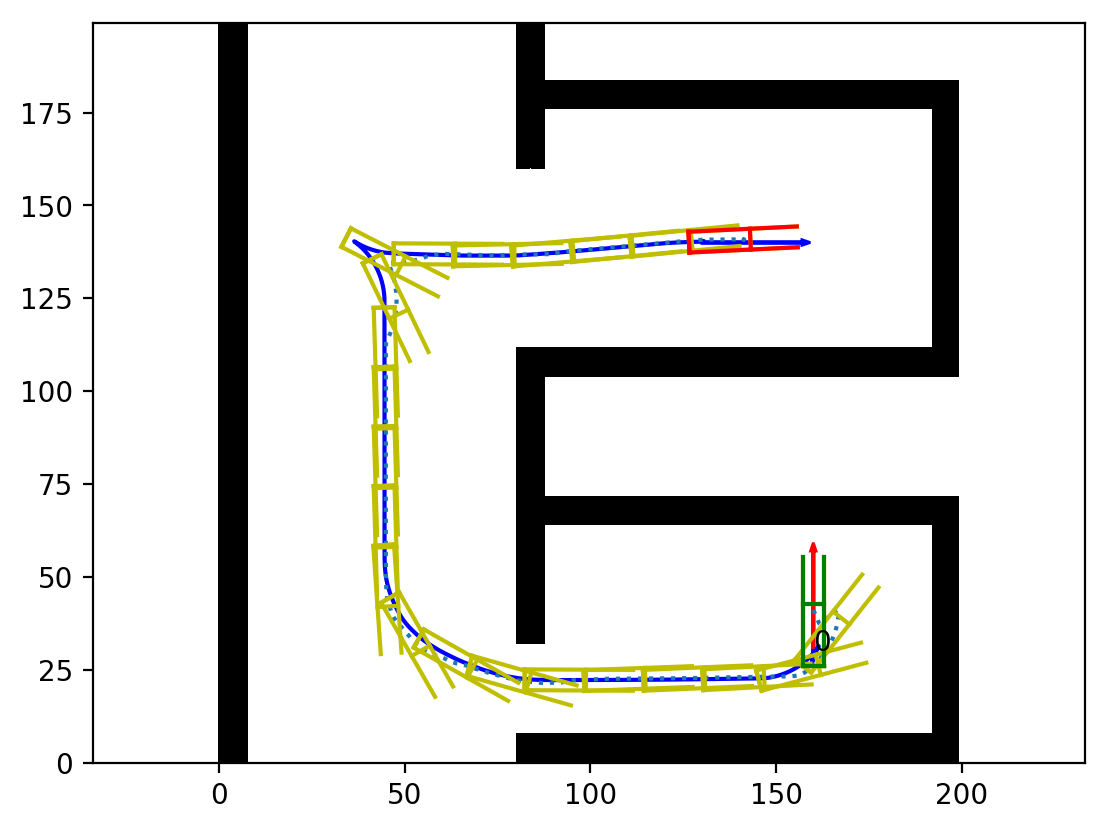

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 6.437822103500366 seconds, and 328 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


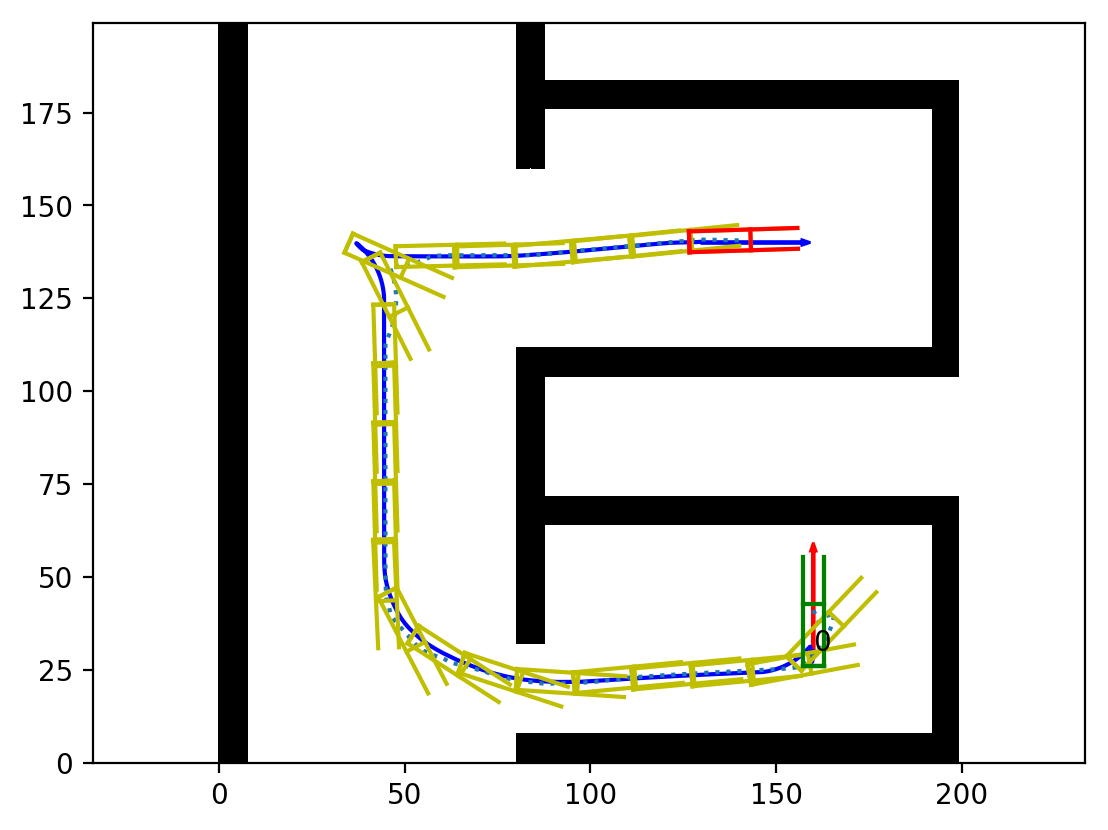

Run n° 2
[[-1.63046154  0.        ]
 [ 0.61507692  0.        ]
 [ 2.86061538  0.        ]
 [ 5.10615385  0.        ]
 [ 7.35169231  0.        ]
 [ 9.59723077  0.        ]
 [11.84276923  0.        ]
 [14.08830769  0.        ]
 [16.33384615  0.        ]
 [18.57938462  0.        ]
 [20.82492308  0.        ]
 [23.07046154  0.        ]]
3d obstacles calculation time: 1.1066014766693115 seconds
3d obstacles distances time: 0.47187113761901855 seconds
3d obstacles distances saturated time: 0.470719575881958 seconds
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 9.544144868850708 seconds, and 326 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


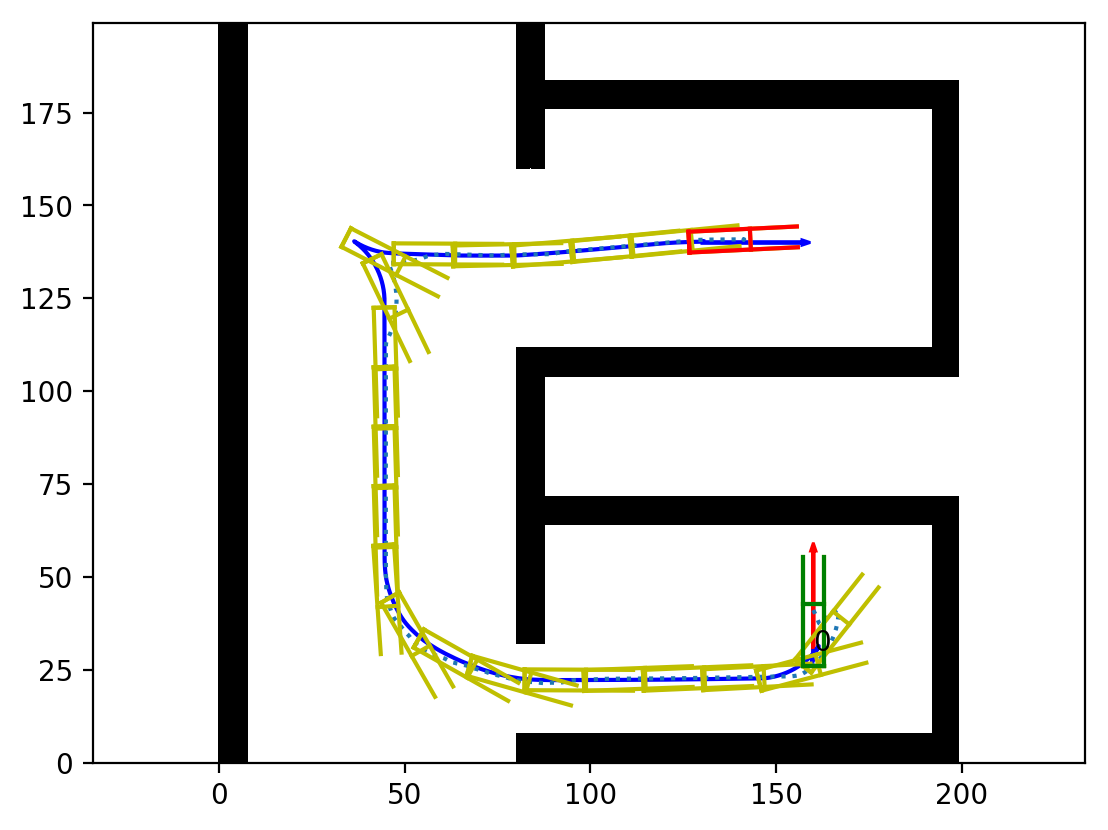

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 8.493024110794067 seconds, and 328 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


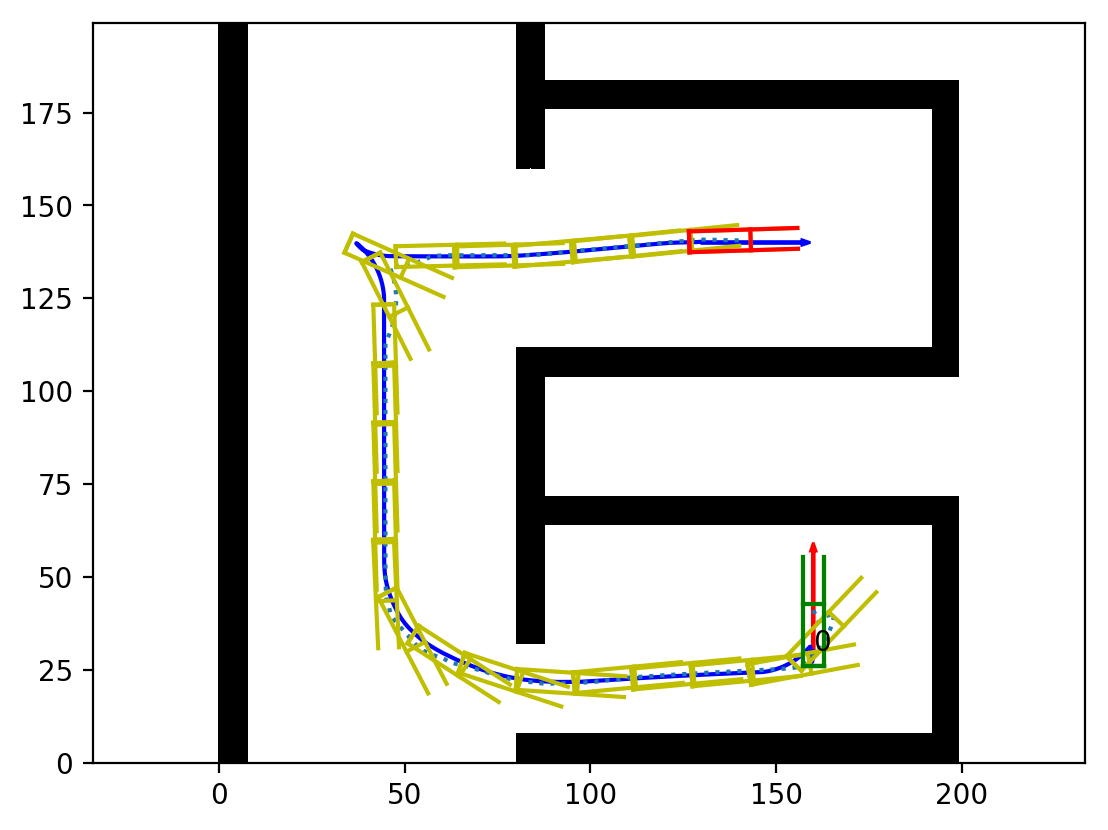

Run n° 3
[[-1.63046154  0.        ]
 [ 0.61507692  0.        ]
 [ 2.86061538  0.        ]
 [ 5.10615385  0.        ]
 [ 7.35169231  0.        ]
 [ 9.59723077  0.        ]
 [11.84276923  0.        ]
 [14.08830769  0.        ]
 [16.33384615  0.        ]
 [18.57938462  0.        ]
 [20.82492308  0.        ]
 [23.07046154  0.        ]]
3d obstacles calculation time: 1.048816204071045 seconds
3d obstacles distances time: 0.4504215717315674 seconds
3d obstacles distances saturated time: 0.47725677490234375 seconds
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 9.687543869018555 seconds, and 325 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


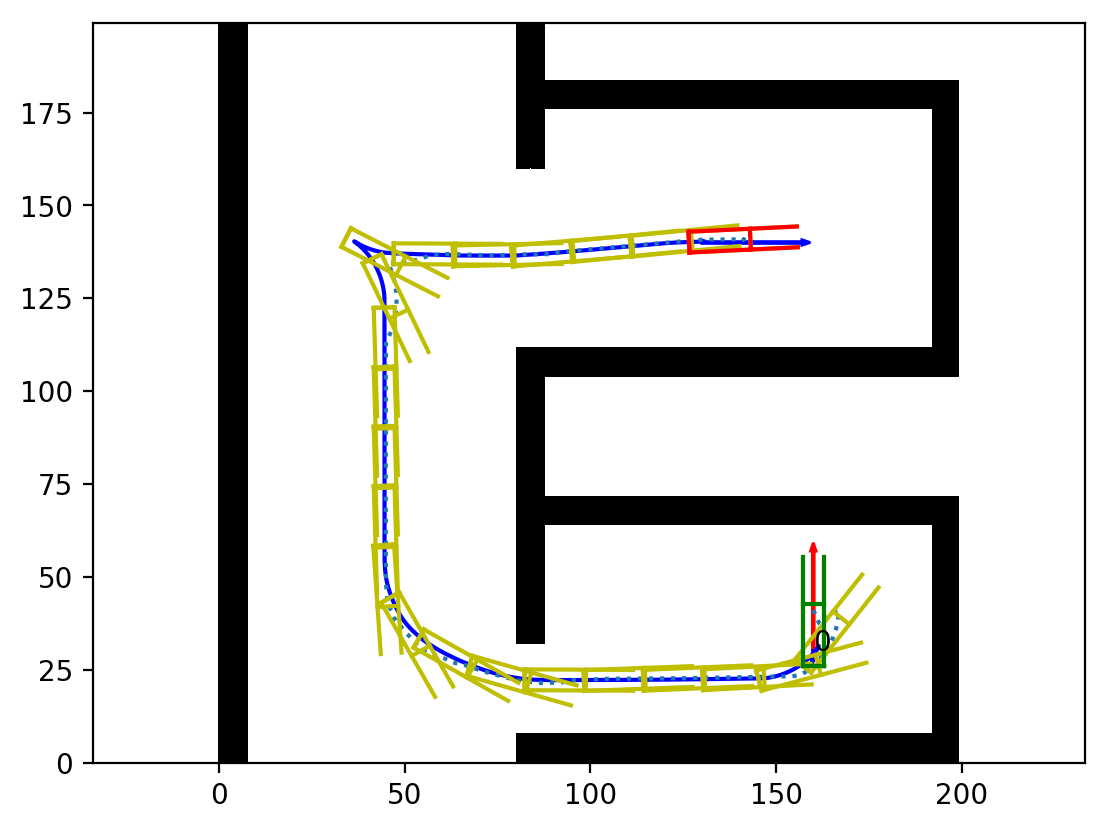

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 8.463160037994385 seconds, and 328 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


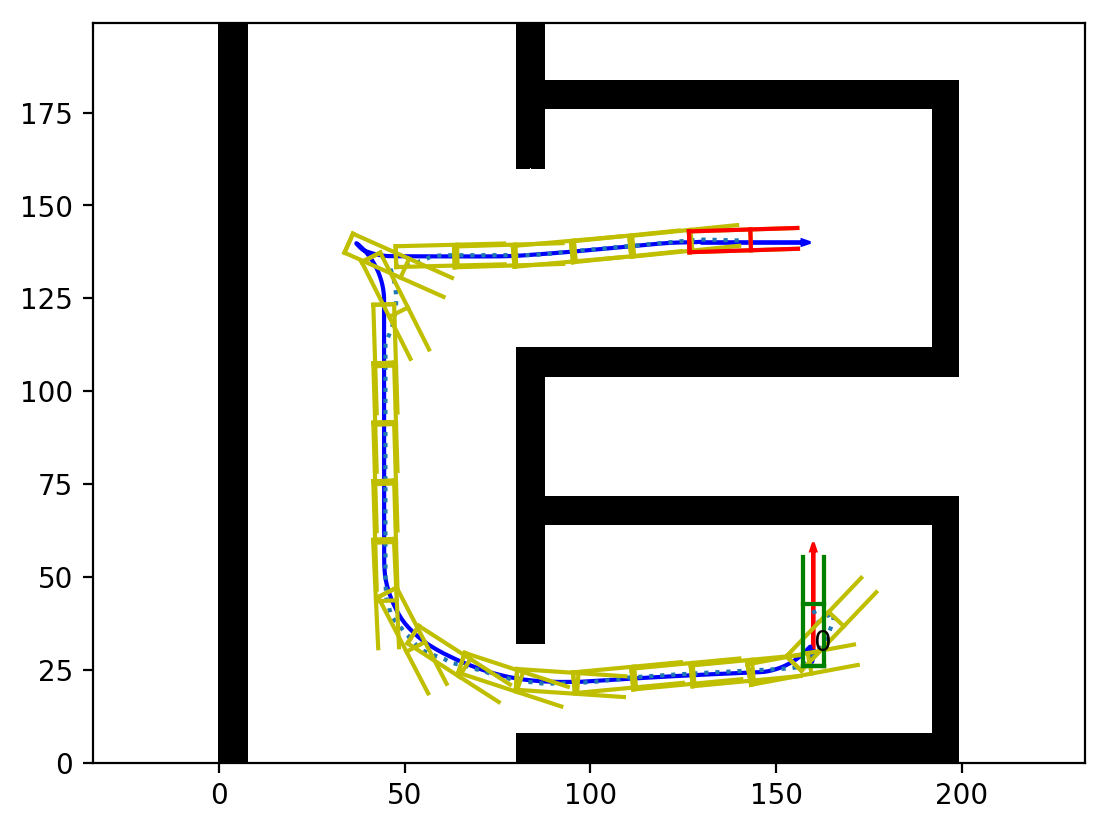

Run n° 4
[[-1.63046154  0.        ]
 [ 0.61507692  0.        ]
 [ 2.86061538  0.        ]
 [ 5.10615385  0.        ]
 [ 7.35169231  0.        ]
 [ 9.59723077  0.        ]
 [11.84276923  0.        ]
 [14.08830769  0.        ]
 [16.33384615  0.        ]
 [18.57938462  0.        ]
 [20.82492308  0.        ]
 [23.07046154  0.        ]]
3d obstacles calculation time: 3.591284990310669 seconds
3d obstacles distances time: 1.3711731433868408 seconds
3d obstacles distances saturated time: 1.3225817680358887 seconds
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 5.6431214809417725 seconds, and 327 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


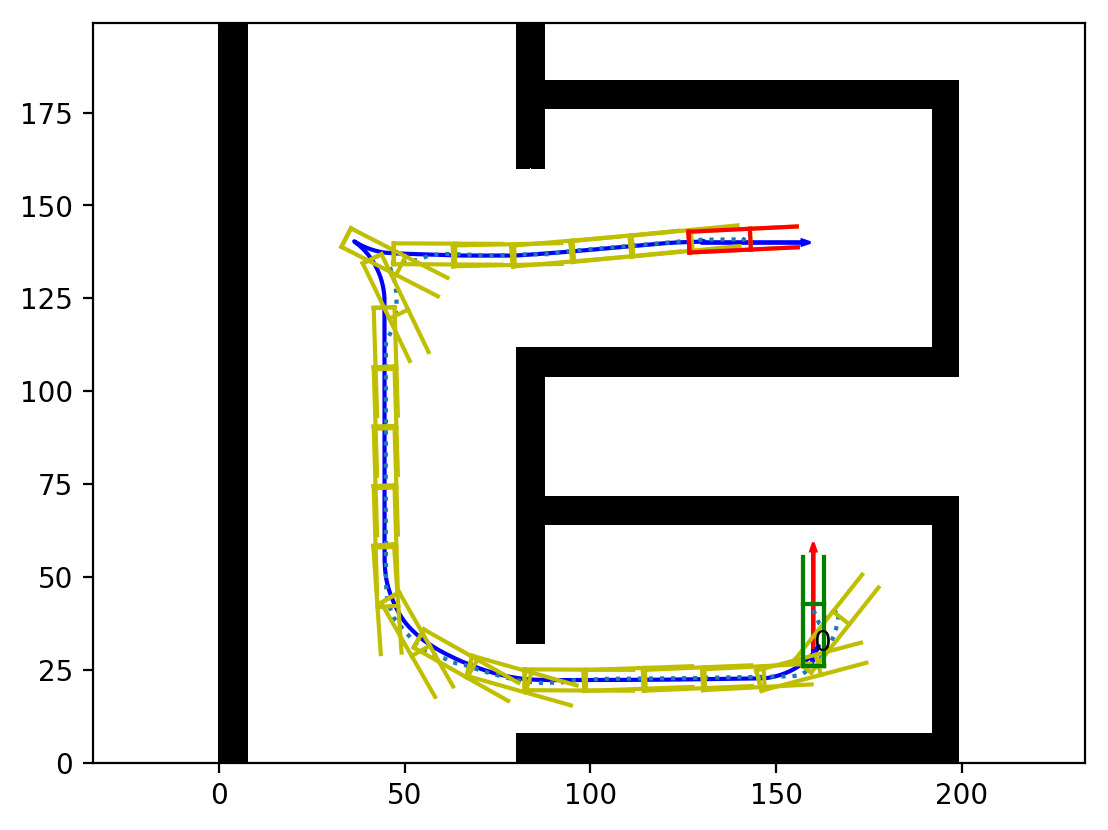

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 4.431414365768433 seconds, and 329 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


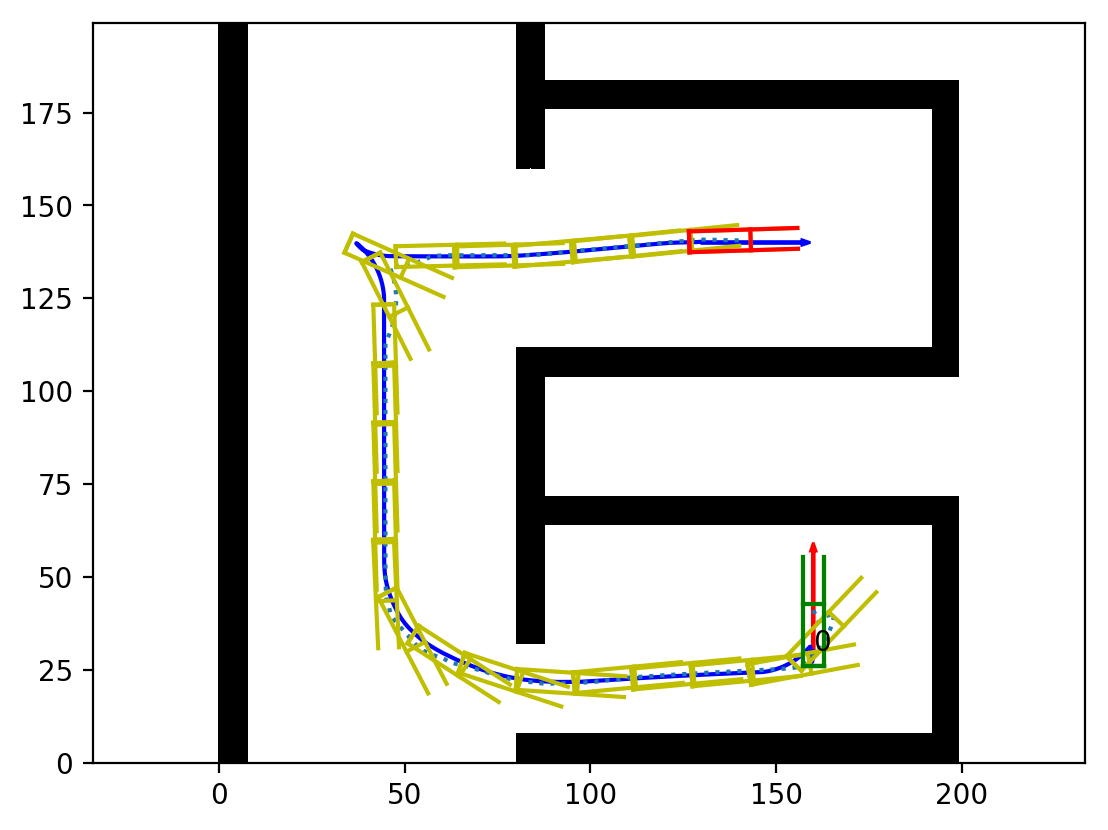

Run n° 5
[[-1.63046154  0.        ]
 [ 0.61507692  0.        ]
 [ 2.86061538  0.        ]
 [ 5.10615385  0.        ]
 [ 7.35169231  0.        ]
 [ 9.59723077  0.        ]
 [11.84276923  0.        ]
 [14.08830769  0.        ]
 [16.33384615  0.        ]
 [18.57938462  0.        ]
 [20.82492308  0.        ]
 [23.07046154  0.        ]]
3d obstacles calculation time: 3.4845213890075684 seconds
3d obstacles distances time: 1.4295310974121094 seconds
3d obstacles distances saturated time: 1.4405603408813477 seconds
Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 4.450997591018677 seconds, and 329 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


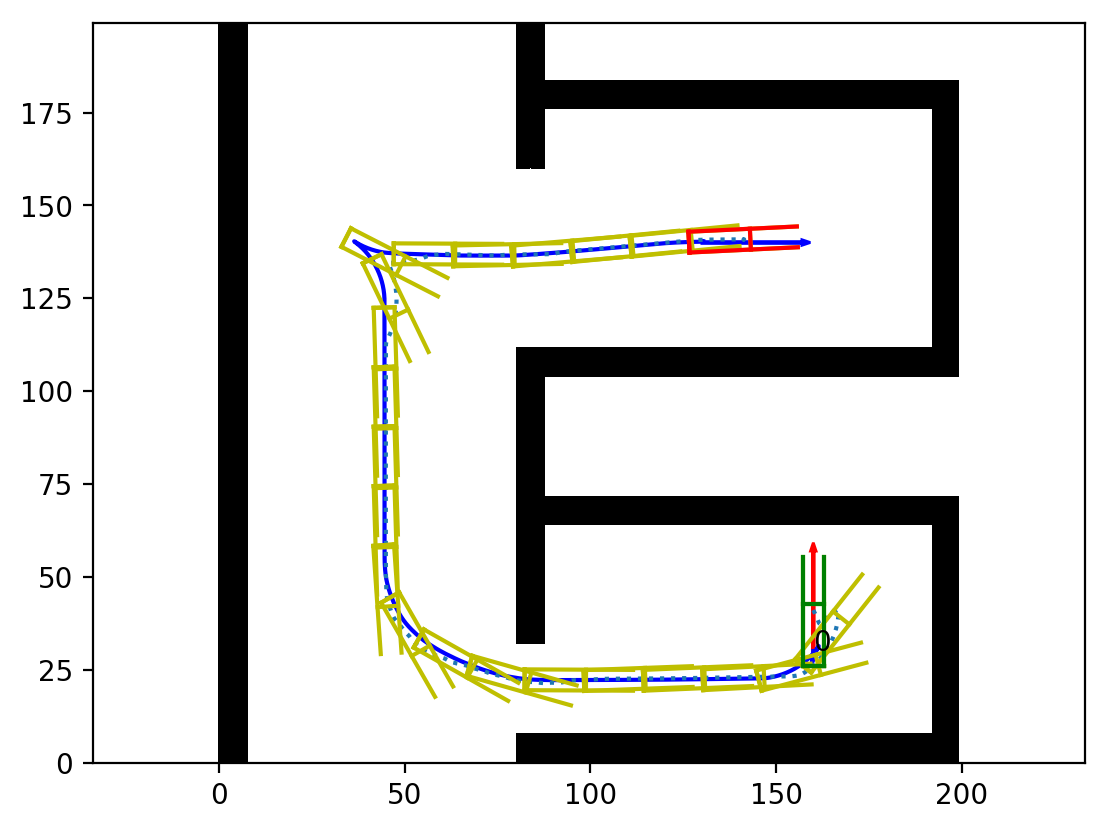

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 4.167414903640747 seconds, and 330 iterations.
Post-Processing
130.0 140.0 133.876 140.0
160.0 30.0 160.0 33.876
[-25.316-2.8j -25.316+2.8j   3.876-2.8j   3.876+2.8j]
[29.192, 5.6]


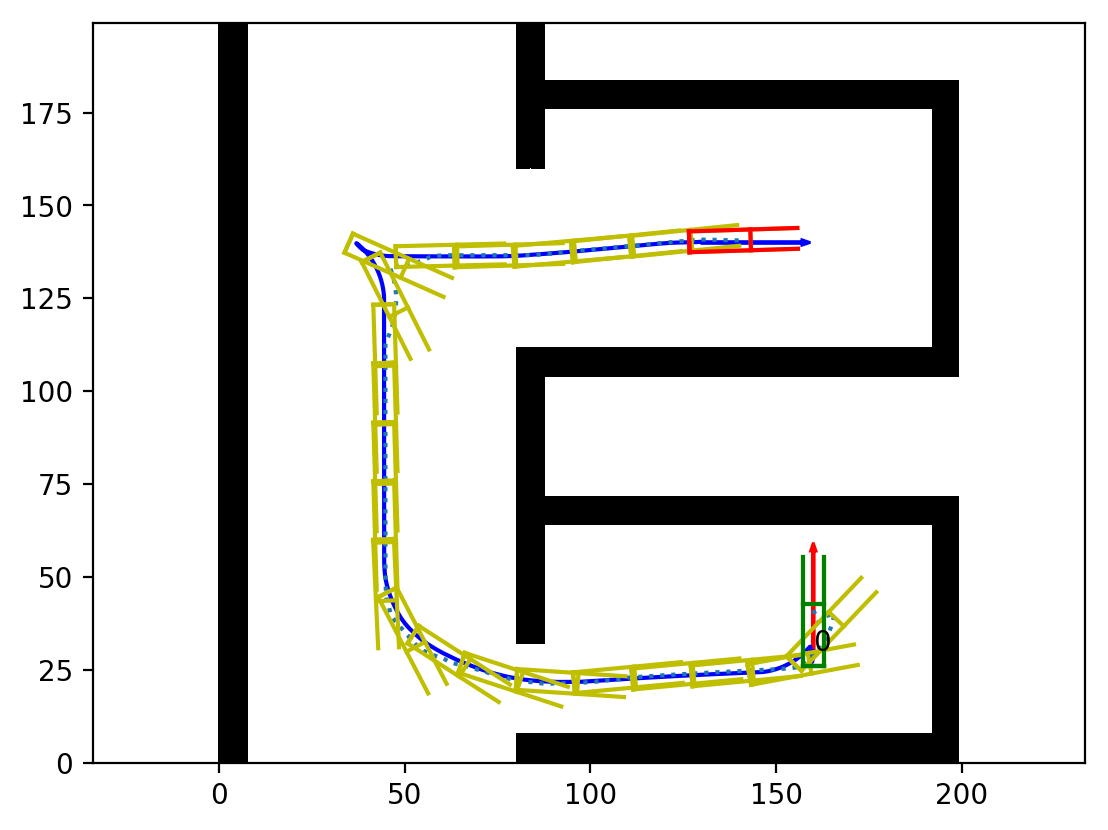

In [23]:
runs = data["runs"]
geos2WS = []
geos4WS = []
list_walls = []
k = 0
for i in runs : 
    k+=1
    print("Run n°",k)
    walls,X,walls_dist,Dxy,Nxy = extract_env(i)
    walls3, walls3_dist, walls3_dist_saturated = build_3d(balls_number, walls_dist,Nxy,Dxy)
    Nx = Nxy[0]
    Ny = Nxy[1]
    seed = xp.r_[i["environment"]["start"],0]
    #seed[0],seed[1] = seed[1],seed[0]
    tips = xp.r_[i["environment"]["goal"],0]
    #tips[0],tips[1] = tips[1],tips[0]
    hfmIn0 = Eikonal.dictIn({
        'model':'DubinsState4',
        'seed':seed, # Compute the paths from a single seed point ...
        'tips':[tips], # ... to two tips points.
        'origin':(0,0, 0,-0.5),
        'gridScales':(Dxy[0],Dxy[1], 2*np.pi/Nθ,1),
        'periodic':[False,False,True,False], # Domain = R^2 x S^1 x A
        'exportActiveNeighs':True,
        'verbosity' : 1,
        'nitermax_o': 4000,
        'exportGeodesicFlow':True,
        'exportValues':True,
    })
    _,hfmOut1=run_controls(hfmIn0.copy(),Dubins_Reduced_controls_2WS(Θ,wheel_base=1.38*zoom_factor,rev_ratio=0.5),
                            fm2=1,saturation = 1,state_transition_costs=1);
    _,hfmOut2=run_controls(hfmIn0.copy(),Dubins_Reduced_controls_4WS(Θ,wheel_base=1.38*zoom_factor,rev_ratio=0.5),
                            fm2=1,saturation = 1,state_transition_costs=1);
    path = hfmOut1['geodesics'][0].T
    geos2WS.append(path.get())
    path = hfmOut2['geodesics'][0].T
    geos4WS.append(path.get())
    list_walls.append(walls)

In [24]:
file_path = 'path4WS.txt'
np.savetxt(file_path, geos4WS[0], delimiter=' ', fmt='%f')
file_path = 'path2WS.txt'
np.savetxt(file_path, geos2WS[0], delimiter=' ', fmt='%f')

In [25]:
# ngeo2 = []
# ngeo4 = []
# for i in range(len(geos2WS)):
#     ngeo = np.vstack((geos2WS[i][:,1],geos2WS[i][:,0],geos2WS[i][:,2])).T
#     ngeo2.append(ngeo)
#     ngeo = np.vstack((geos4WS[i][:,1],geos4WS[i][:,0],geos4WS[i][:,2])).T
#     ngeo4.append(ngeo)
ngeo2 = geos2WS
ngeo4 = geos4WS

In [26]:
ngeo2 = []
ngeo4 = []
for i in range(len(geos2WS)):
    ngeo = np.vstack((geos2WS[i][:,0],geos2WS[i][:,1],geos2WS[i][:,2]+np.pi)).T
    ngeo2.append(ngeo)
    ngeo = np.vstack((geos4WS[i][:,0],geos4WS[i][:,1],geos4WS[i][:,2]+np.pi)).T
    ngeo4.append(ngeo)

Visualizing comparison_extend_functions_RC.json
Saved traj_planners_HFM.pdf.


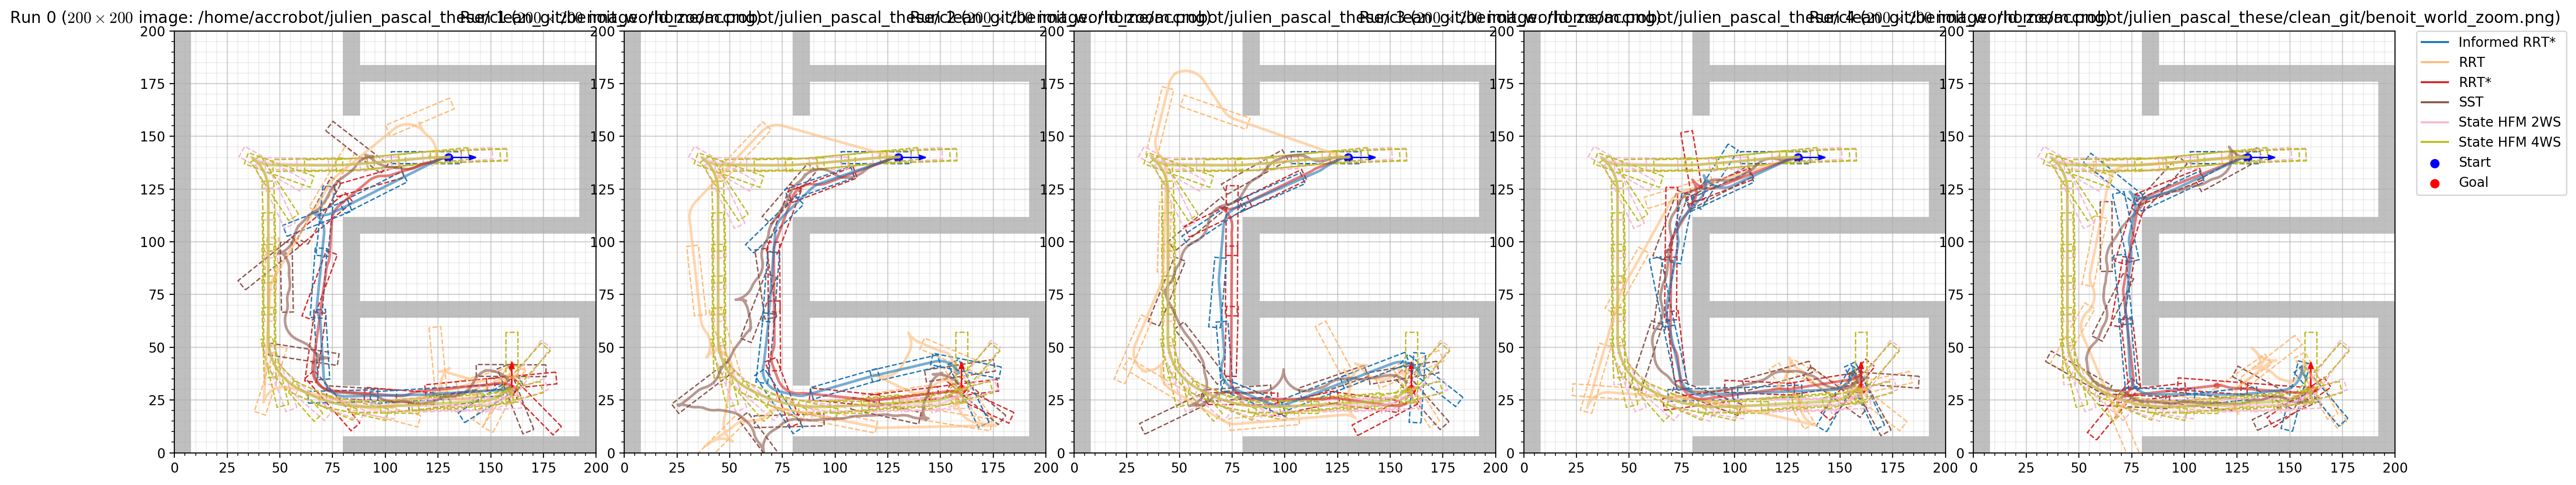

In [27]:
visualize('comparison_extend_functions_RC.json',additional_path =[ngeo2,ngeo4] , plot_every_nth_polygon=60,draw_start_goal_thetas=True, save_file="traj_planners_HFM.pdf")

In [28]:
from metrics_bindings import compute_path_length, compute_curvature, compute_smoothness, compute_clearing_distances, compute_aol, compute_clearing_distances

In [29]:
# %matplotlib inline
import json
import numpy as np
from scipy import ndimage
def extract_env(run):
    map_string = run["environment"]["map"]
    width = run["environment"]["width"]
    height = len(map_string) // width
    walls = np.array([int(char) for char in map_string]).reshape(height, width).T
    
    Nx = width # Number of points along the x-axis
    Ny = height
    
    dx = walls.shape[0]/Nx # Distance between consecutive pixels, in original coordinates
    dy = walls.shape[1]/Ny
    walls = ndimage.zoom(walls.astype(float),1/dx,order=1)>0.5
    
    X = np.meshgrid(np.arange(walls.shape[0])*dx,np.arange(walls.shape[1])*dy,indexing='ij')
    walls_dist = ndimage.distance_transform_edt(np.logical_not(walls),sampling=dx)
    
    return walls,X,walls_dist,[dx,dy],[Nx,Ny]

# data = json.load(open('comparison_extend_functions.json', "r"))

# walls,X,walls_dist,Dxy,Nxy = extract_env(data["runs"][0])
path = geos2WS[-1]

# length = compute_path_length(path)
# max_curv, norm_curv = compute_curvature(path)
# aol = compute_aol(path)
clearings = compute_clearing_distances(path = path, binary_map = walls.T)

Info:    Computing distances via DEAD_RECKONING


         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp


In [30]:
length_m = 0
max_curv_m = 0
norm_curv_m = 0
aol_m = 0

stats = {
    'StateHFM_2WS': {  # Your method name
        'path_length': [],  
        'aol': [],
        'normalized_curvature': [],
        'max_curvature': [],
        'max_clearing_distance':[],
        'mean_clearing_distance':[],
        'median_clearing_distance':[],
        'min_clearing_distance':[]
    },
    'StateHFM_4WS': {  # Your method name
        'path_length': [],  
        'aol': [],
        'normalized_curvature': [],
        'max_curvature': [],
        'max_clearing_distance':[],
        'mean_clearing_distance':[],
        'median_clearing_distance':[],
        'min_clearing_distance':[]
    }
}

for i in range(2):#len(geos2WS)) : 
    length = compute_path_length(geos2WS[i])
    max_curv, norm_curv = compute_curvature(geos2WS[i])
    aol = compute_aol(geos2WS[i])
    clearings = compute_clearing_distances(path = geos2WS[i], binary_map = list_walls[i].T)
    
    stats['StateHFM_2WS']['path_length'].append(length)
    stats['StateHFM_2WS']['aol'].append(aol)
    stats['StateHFM_2WS']['normalized_curvature'].append(norm_curv)
    stats['StateHFM_2WS']['max_curvature'].append(max_curv)
    stats['StateHFM_2WS']['max_clearing_distance'].append(np.max(clearings))
    stats['StateHFM_2WS']['min_clearing_distance'].append(np.min(clearings))
    stats['StateHFM_2WS']['mean_clearing_distance'].append(np.mean(clearings))
    stats['StateHFM_2WS']['median_clearing_distance'].append(np.median(clearings))

for i in range(2):#len(geos4WS)) : 
    length = compute_path_length(geos4WS[i])
    max_curv, norm_curv = compute_curvature(geos4WS[i])
    aol = compute_aol(geos4WS[i])
    clearings = compute_clearing_distances(path = geos4WS[i], binary_map = list_walls[i].T)
    
    stats['StateHFM_4WS']['path_length'].append(length)
    stats['StateHFM_4WS']['aol'].append(aol)
    stats['StateHFM_4WS']['normalized_curvature'].append(norm_curv)
    stats['StateHFM_4WS']['max_curvature'].append(max_curv)
    stats['StateHFM_4WS']['max_clearing_distance'].append(np.max(clearings))
    stats['StateHFM_4WS']['min_clearing_distance'].append(np.min(clearings))
    stats['StateHFM_4WS']['mean_clearing_distance'].append(np.mean(clearings))
    stats['StateHFM_4WS']['median_clearing_distance'].append(np.median(clearings))
    


Evaluate Metric in geometric space 
Info:    Computing distances via DEAD_RECKONING
Evaluate Metric in geometric space 
Info:    Computing distances via DEAD_RECKONING
Evaluate Metric in geometric space 
Info:    Computing distances via DEAD_RECKONING
Evaluate Metric in geometric space 
Info:    Computing distances via DEAD_RECKONING


         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/accrobot/ompl-1.5.2/src/ompl/base/src/SpaceInformation.cpp
         at line 63 in /home/acc

In [31]:
stats

{'StateHFM_2WS': {'path_length': [328.7545596073766, 328.7545687172874],
  'aol': [0.059491828592624973, 0.0594914042232082],
  'normalized_curvature': [1.015547850441508, 1.014774400071649],
  'max_curvature': [5.1229346212085956, 5.122984428448998],
  'max_clearing_distance': [38.9614697307729, 38.961470982132845],
  'mean_clearing_distance': [24.97758807641581, 24.977587834603703],
  'median_clearing_distance': [26.641206741333008, 26.641204833984375],
  'min_clearing_distance': [8.089157027985822, 8.089160790868483]},
 'StateHFM_4WS': {'path_length': [323.1072013869578, 323.1072014737139],
  'aol': [0.04191111662313814, 0.04191111661188477],
  'normalized_curvature': [0.8852455569957063, 0.8852548393382167],
  'max_curvature': [4.672979645954083, 4.672979645954083],
  'max_clearing_distance': [39.01338962747315, 39.01338962747315],
  'mean_clearing_distance': [25.324477285979686, 25.324477301026434],
  'median_clearing_distance': [26.77179718017578, 26.77179718017578],
  'min_clear

Visualizing comparison_extend_functions_RC.json...


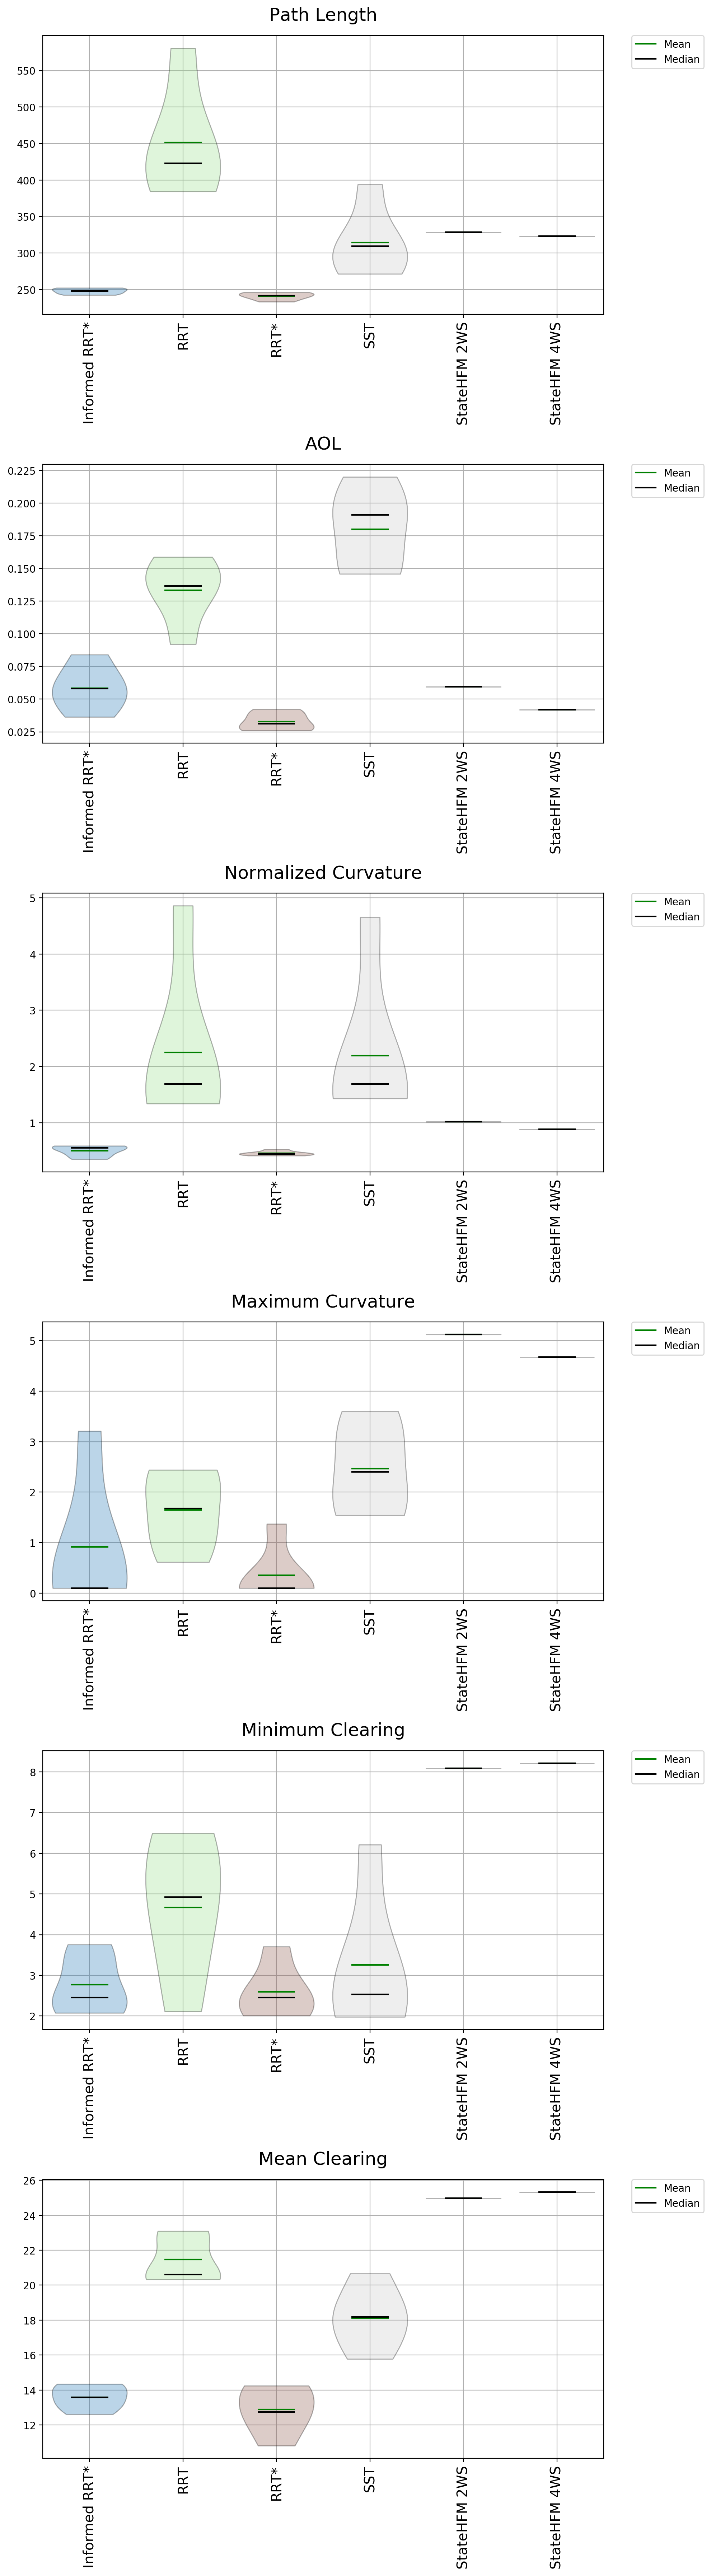

Visualizing comparison_extend_functions_RC.json...


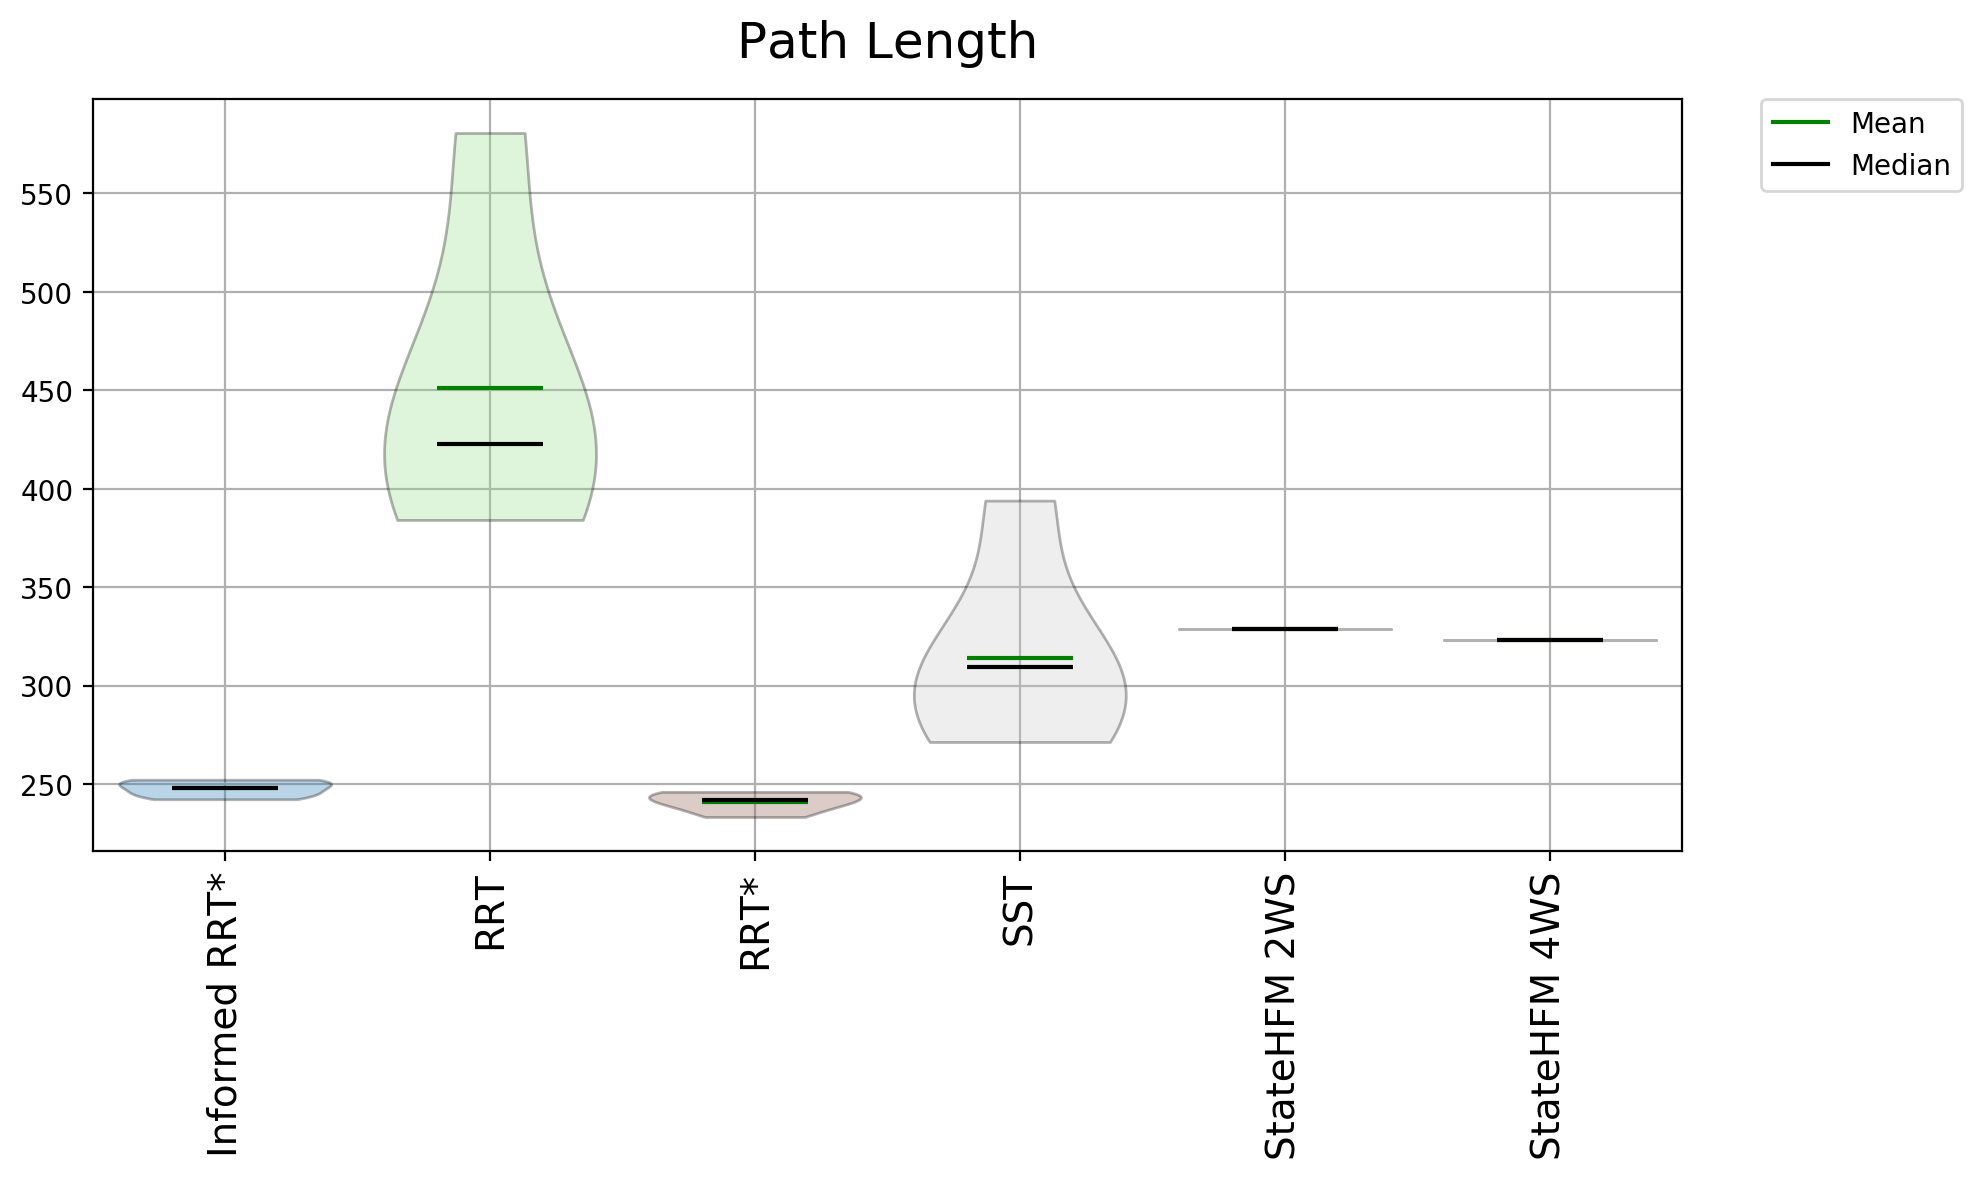

Visualizing comparison_extend_functions_RC.json...


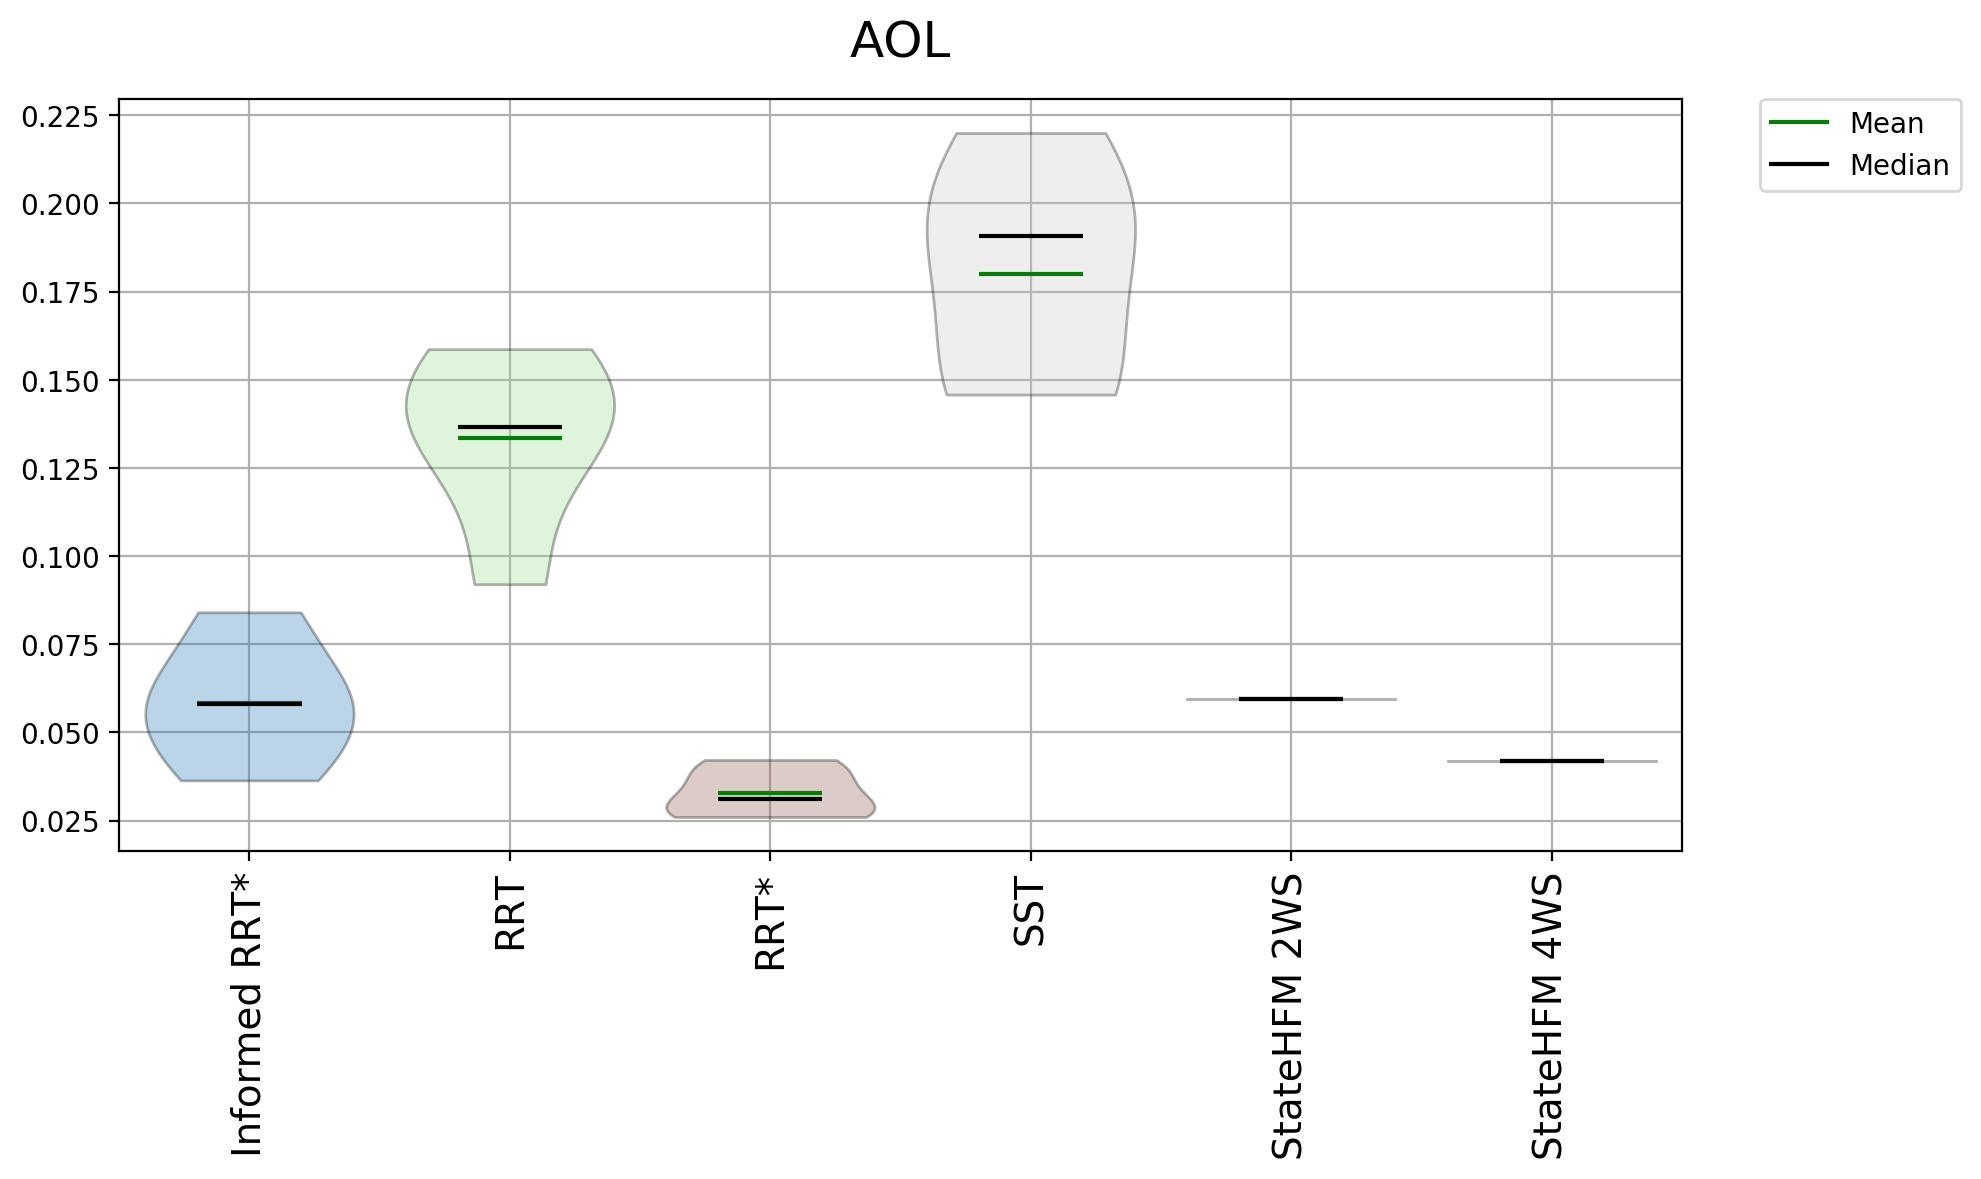

Visualizing comparison_extend_functions_RC.json...


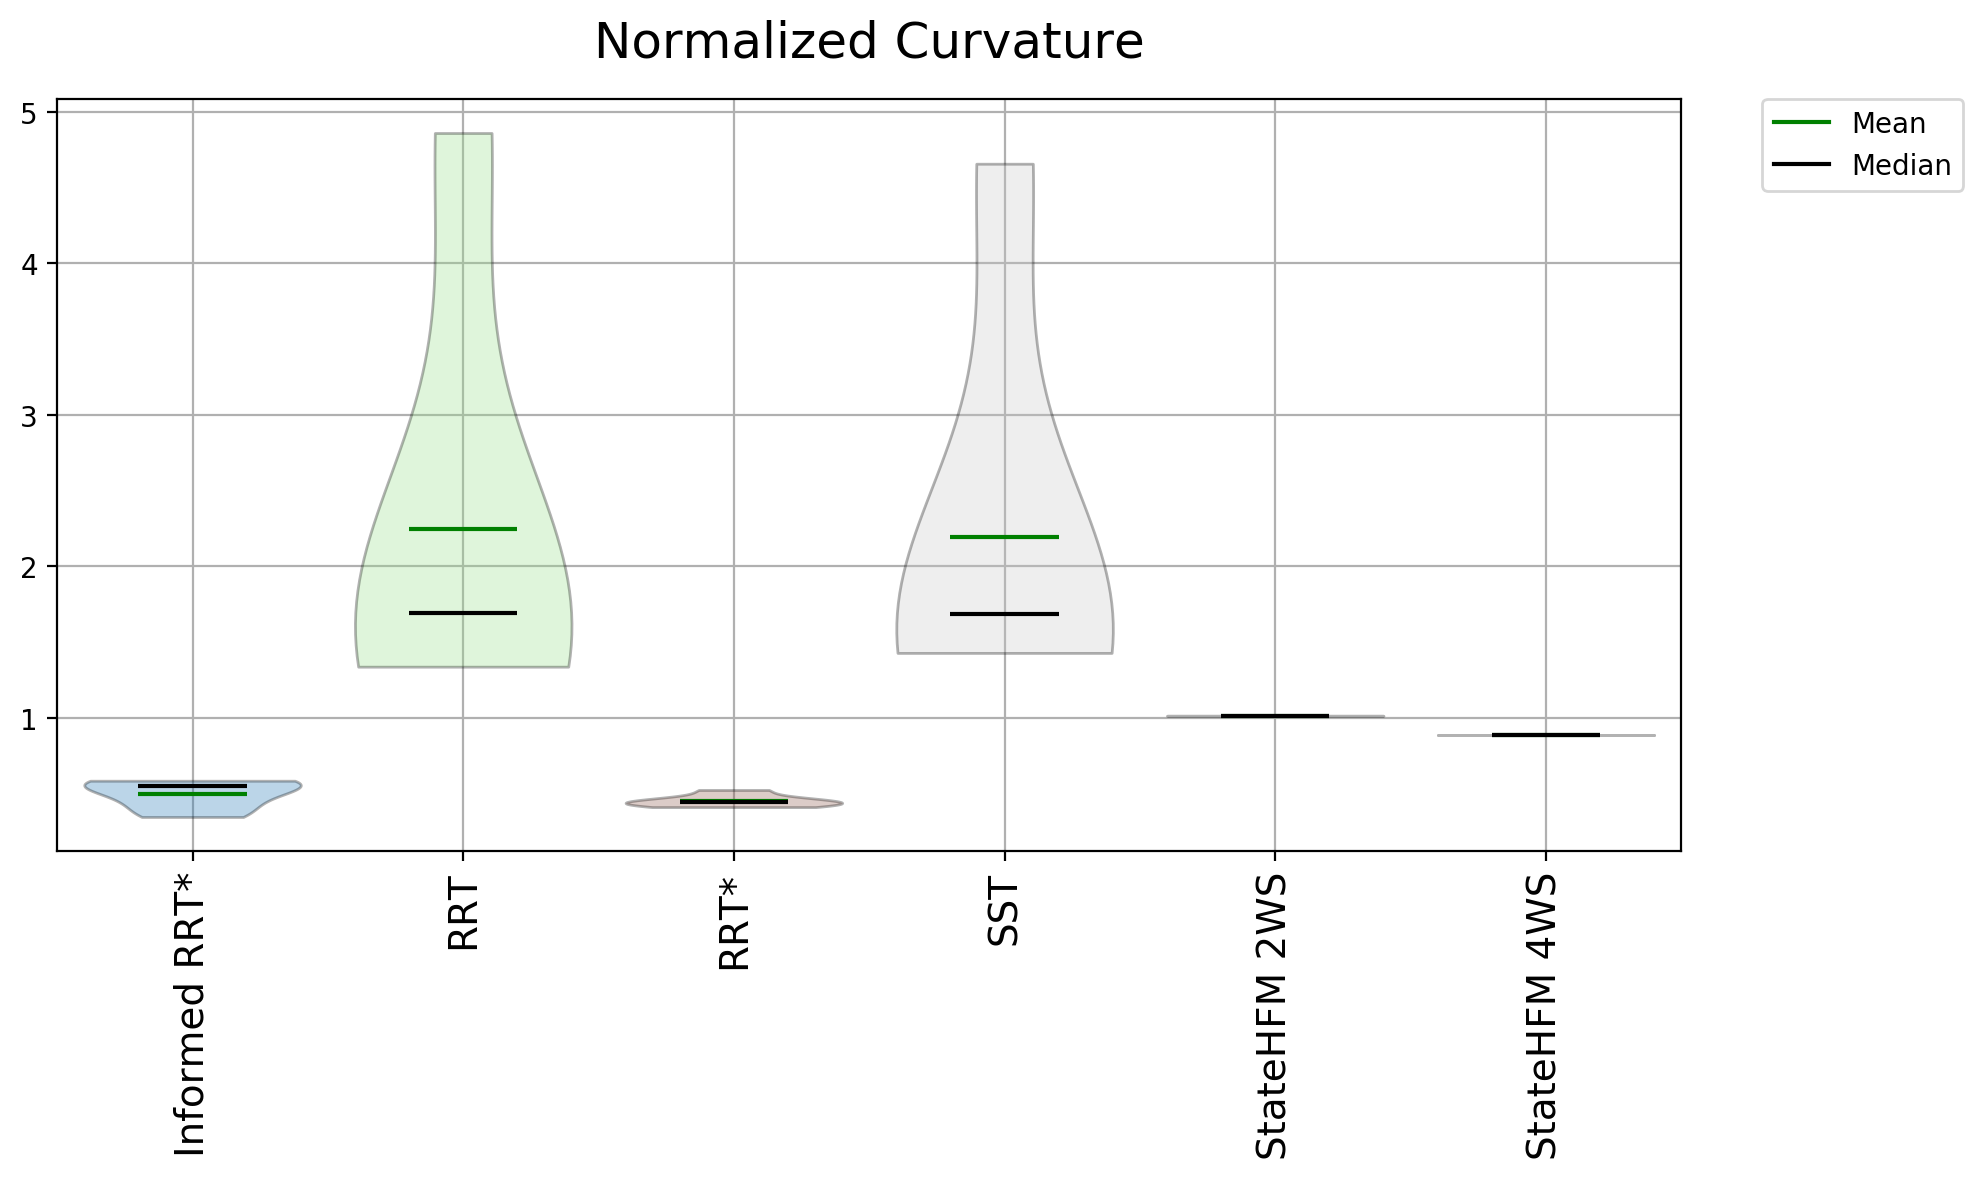

Visualizing comparison_extend_functions_RC.json...
Saved HC_StateHFM_max_curvature_comparaison.pdf.


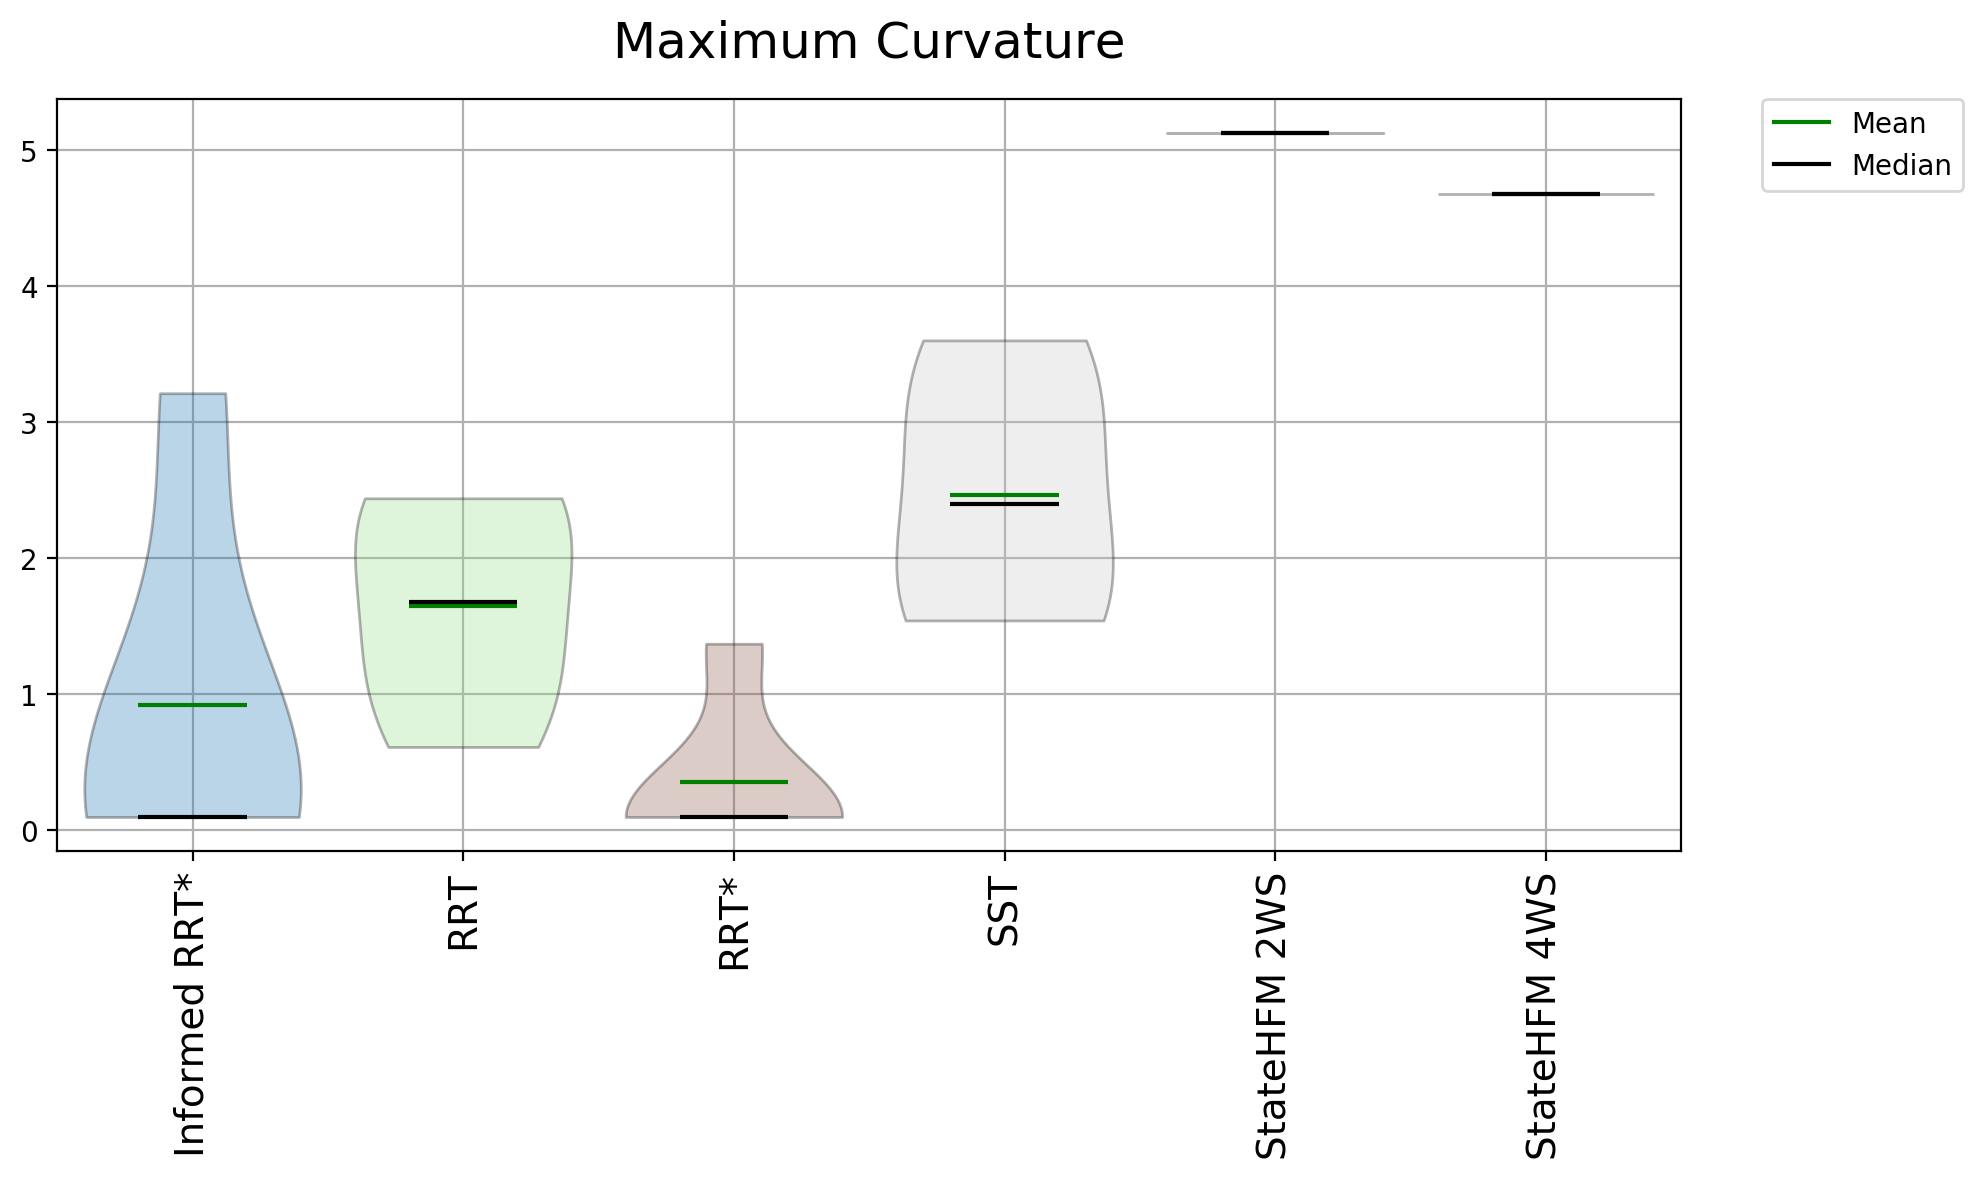

Visualizing comparison_extend_functions_RC.json...


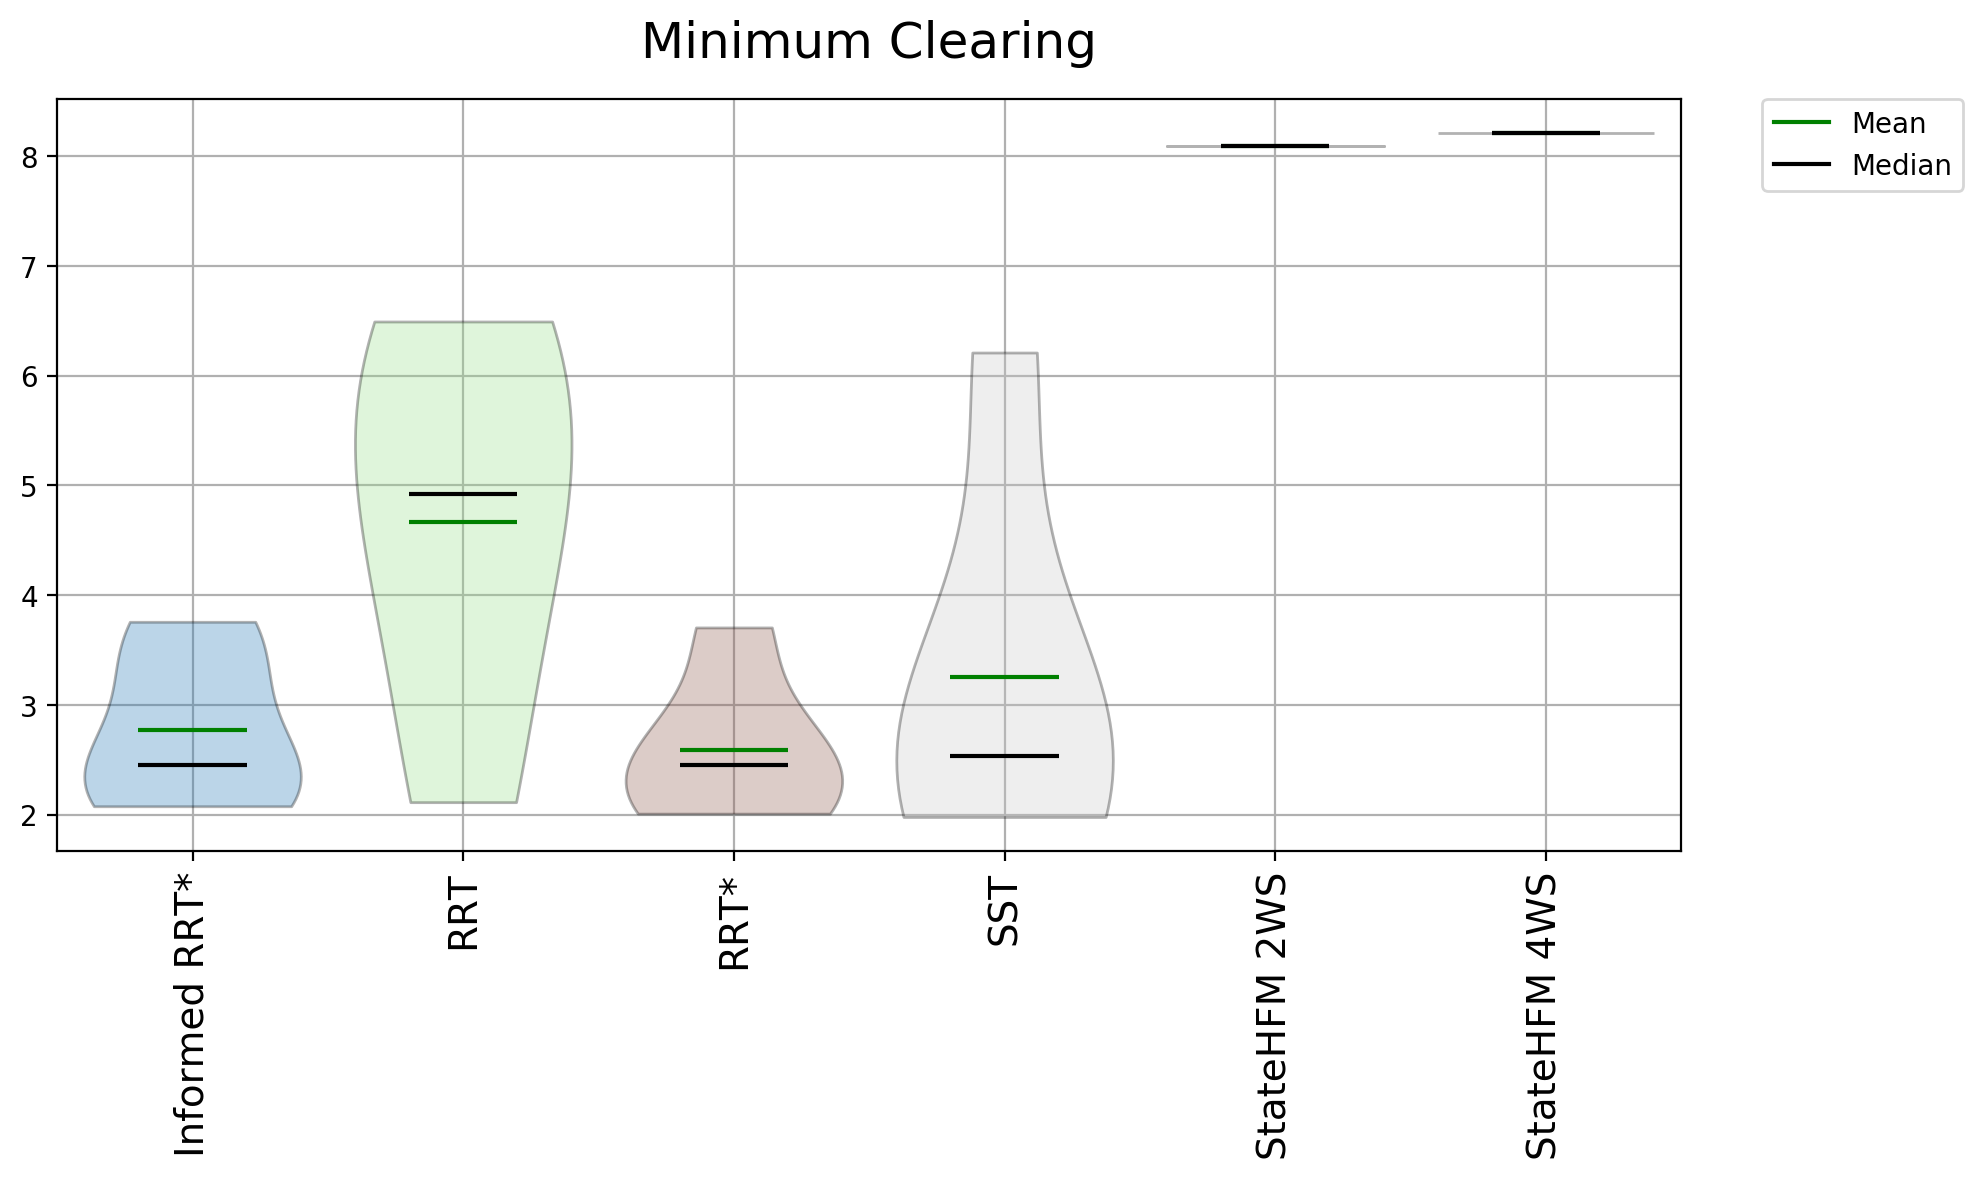

Visualizing comparison_extend_functions_RC.json...


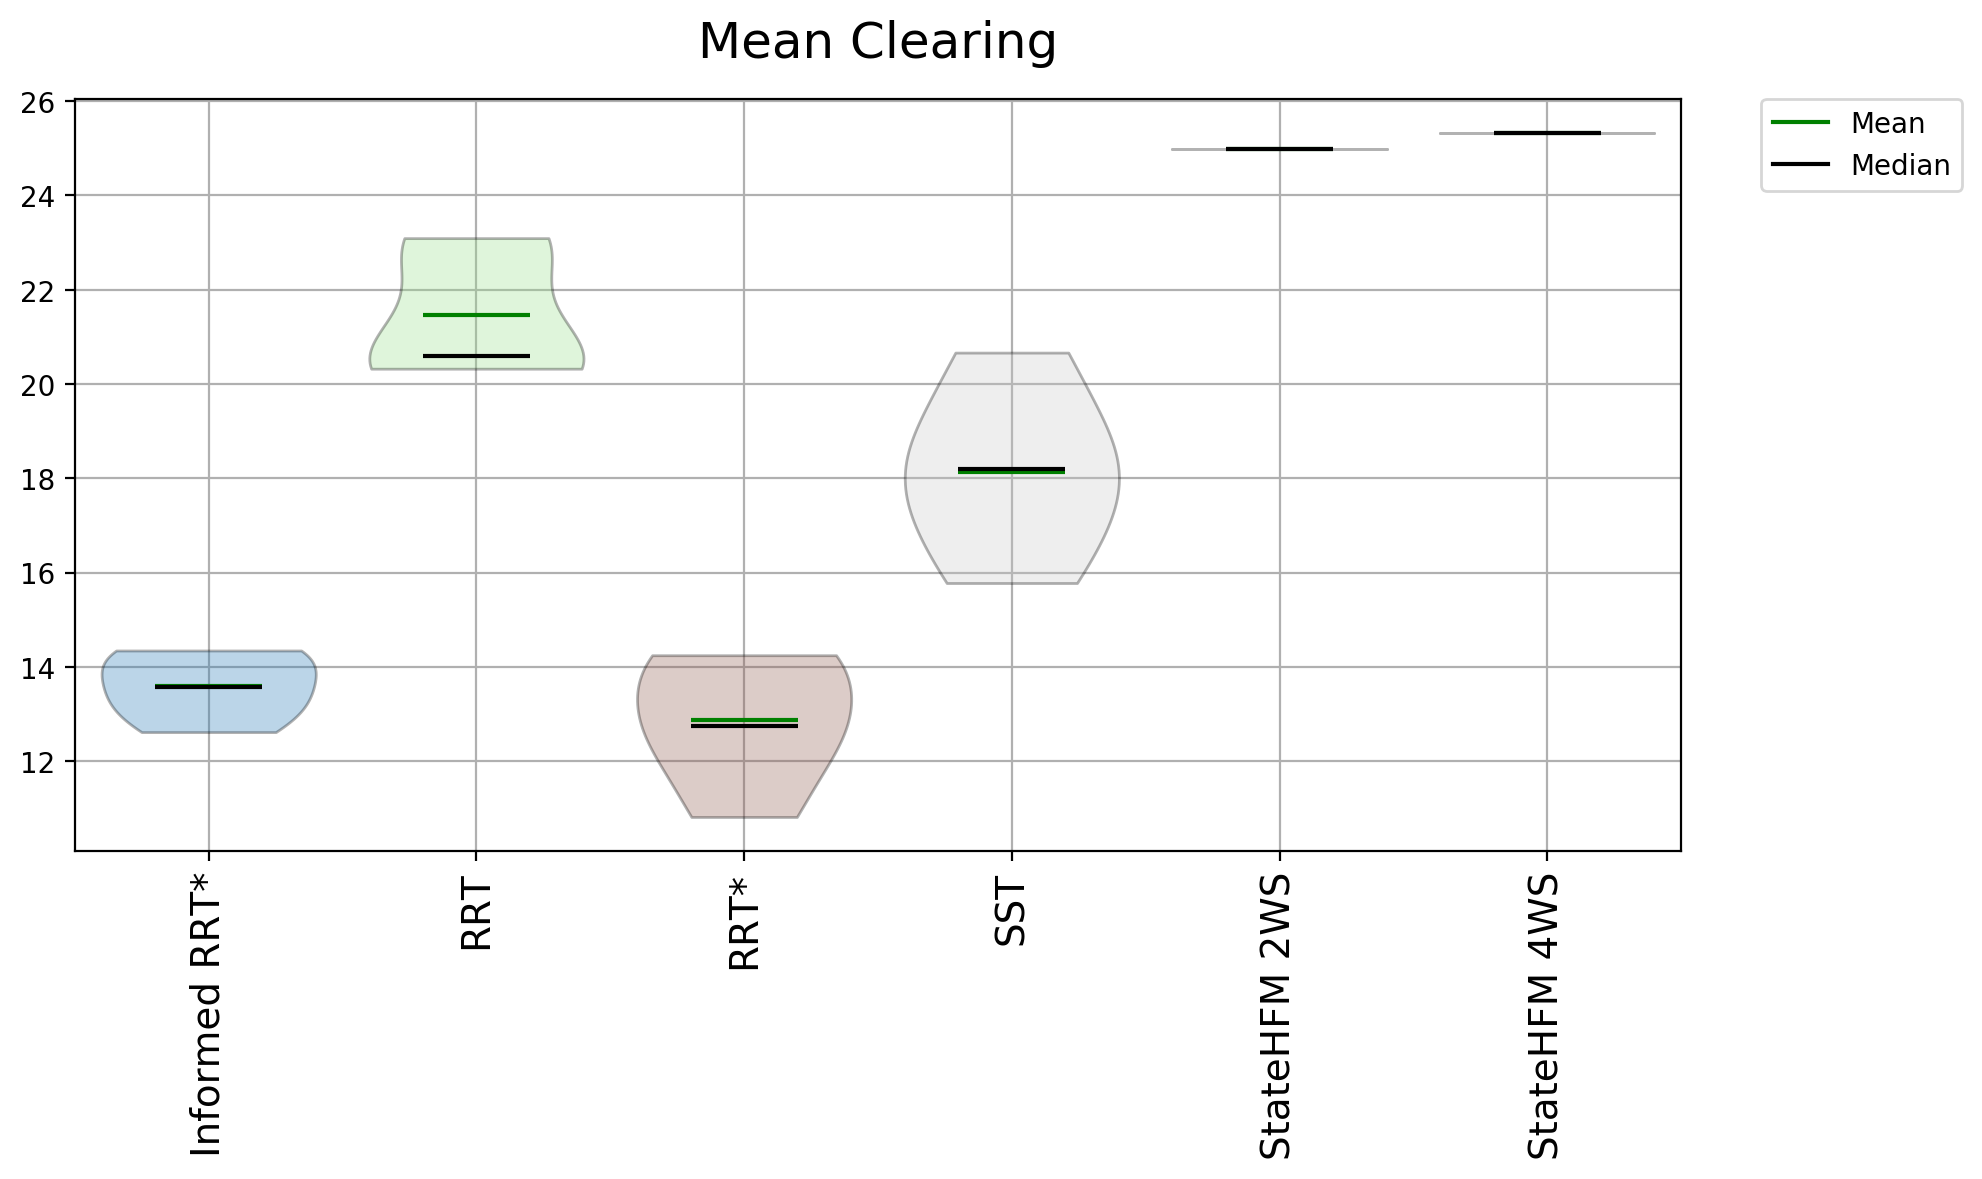

Visualizing comparison_extend_functions_RC.json...


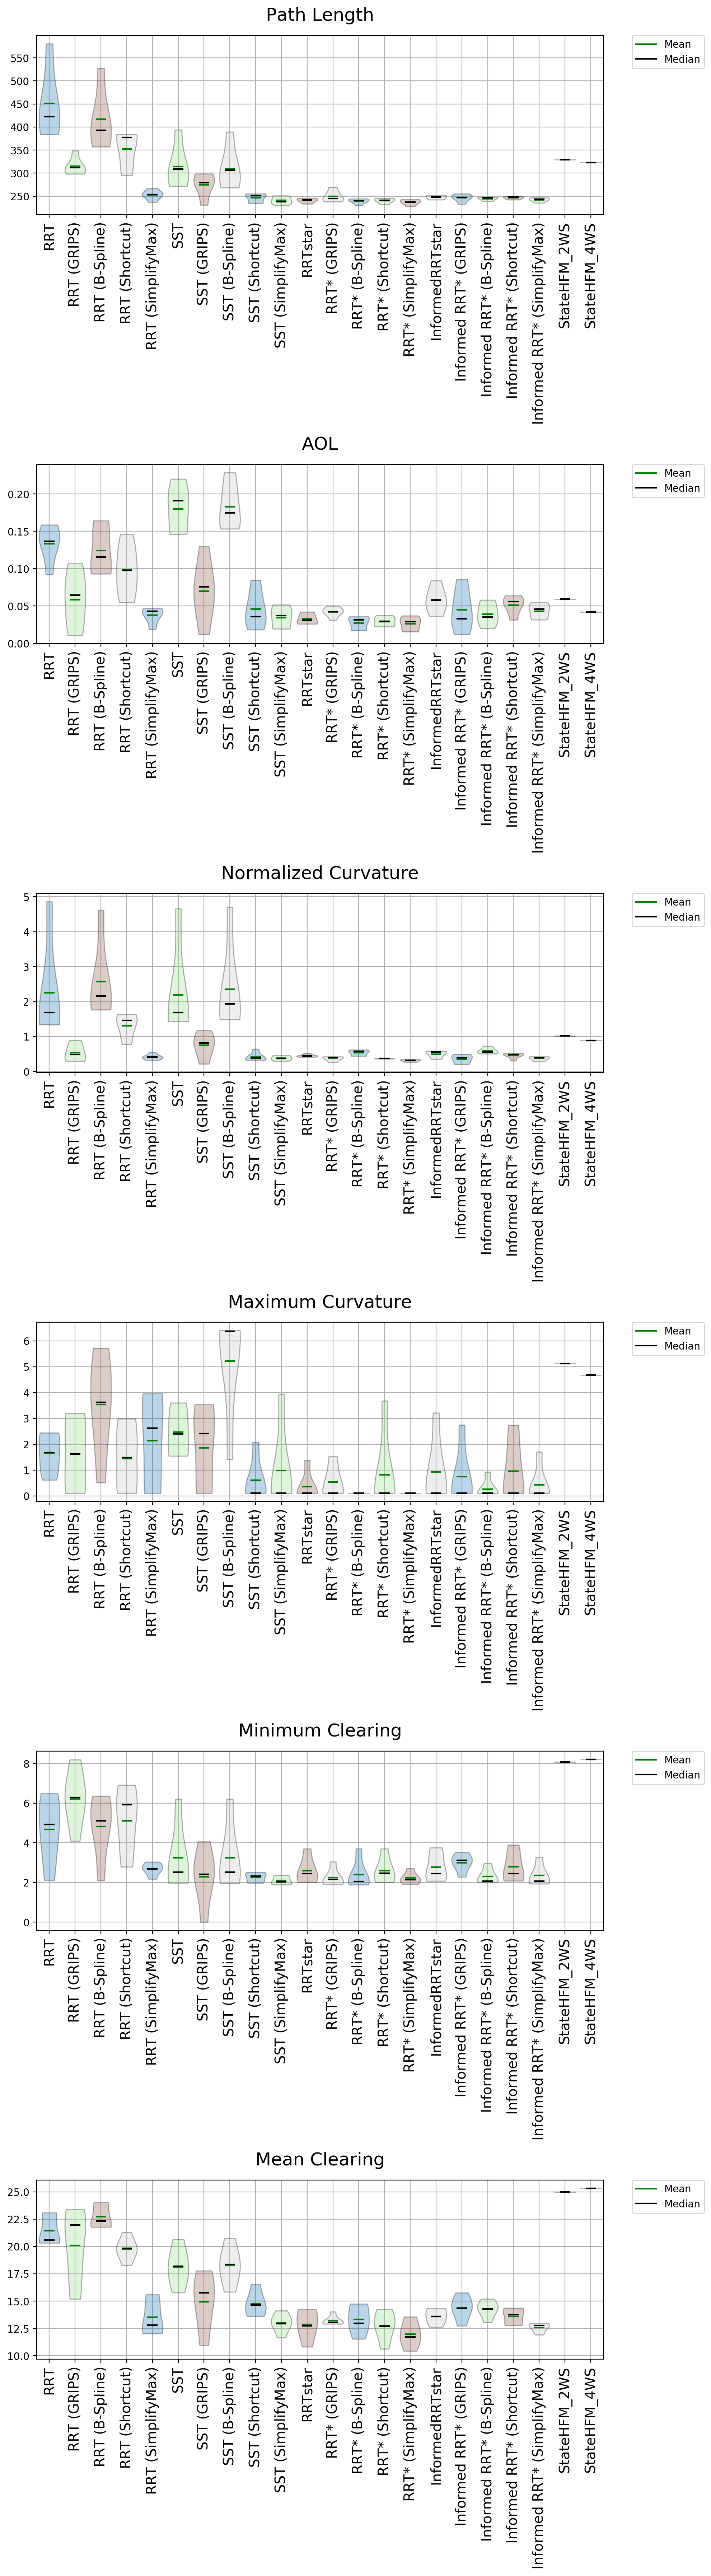

In [33]:
from plot_stats import plot_planner_stats

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='path_length, aol, normalized_curvature, max_curvature, min_clearing_distance, mean_clearing_distance',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_comparaison.pdf"
                   )  # Only show planners you want to compare with

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='path_length',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_length_comparaison.pdf"
                   )  # Only show planners you want to compare with

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='aol',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_aol_comparaison.pdf"
                   )  # Only show planners you want to compare with

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='normalized_curvature',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_normalized_curvature_comparaison.pdf"
                   )  # Only show planners you want to compare with

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='max_curvature',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_max_curvature_comparaison.pdf"
                   )  # Only show planners you want to compare withmin_clearing_distance

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='min_clearing_distance',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_min_clearing_distance_comparaison.pdf"
                   )  # Only show planners you want to compare with

plot_planner_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='mean_clearing_distance',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst'
                   #save_file ="HC_StateHFM_mean_clearing_distance_comparaison.pdf"
                   )  # Only show planners you want to compare with


plot_smoother_stats('comparison_extend_functions_RC.json',
                   custom_stats=stats,  # Add your custom stats
                   metrics='path_length, aol, normalized_curvature, max_curvature, min_clearing_distance, mean_clearing_distance',
                   max_plots_per_line=1,  # Single row
                   combine_views=True,  # All in one plot
                   plot_violins=True,  # Use violin plots for methods with multiple runs
                   fig_width=10,  # Adjust figure width
                   fig_height=6,  # Adjust figure height
                   #ignore_planners='bfmt,est,kpiece,pdst,prm,prmstar,rrtsharp,rrtstar,sbl,spars,spars2,sst,stride,fppdst',
                   # num_colors=100,
                   #save_file ="HC_smoother_StateHFM_comparaison.pdf"
                   )  # Only show planners you want to compare with





plt.show()